## 美国职业棒球数据分析U报告 1985-2015

In [1]:
START_YEAR = 1985
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

读取球队数据

In [2]:

origin_df = pd.read_csv('./baseballdatabank-master/core/Teams.csv')
print origin_df.columns
years_df = origin_df.set_index('yearID')
teams_df = origin_df.set_index('teamID')

Index([u'yearID', u'lgID', u'teamID', u'franchID', u'divID', u'Rank', u'G',
       u'Ghome', u'W', u'L', u'DivWin', u'WCWin', u'LgWin', u'WSWin', u'R',
       u'AB', u'H', u'2B', u'3B', u'HR', u'BB', u'SO', u'SB', u'CS', u'HBP',
       u'SF', u'RA', u'ER', u'ERA', u'CG', u'SHO', u'SV', u'IPouts', u'HA',
       u'HRA', u'BBA', u'SOA', u'E', u'DP', u'FP', u'name', u'park',
       u'attendance', u'BPF', u'PPF', u'teamIDBR', u'teamIDlahman45',
       u'teamIDretro'],
      dtype='object')


读取薪资数据

In [3]:
salaries_df = pd.read_csv('./baseballdatabank-master/core/Salaries.csv')
salaries_df = salaries_df[salaries_df['yearID']>=START_YEAR]
print salaries_df


       yearID teamID lgID   playerID    salary
0        1985    ATL   NL  barkele01    870000
1        1985    ATL   NL  bedrost01    550000
2        1985    ATL   NL  benedbr01    545000
3        1985    ATL   NL   campri01    633333
4        1985    ATL   NL  ceronri01    625000
5        1985    ATL   NL  chambch01    800000
6        1985    ATL   NL  dedmoje01    150000
7        1985    ATL   NL  forstte01    483333
8        1985    ATL   NL  garbege01    772000
9        1985    ATL   NL  harpete01    250000
10       1985    ATL   NL  hornebo01   1500000
11       1985    ATL   NL  hubbagl01    455000
12       1985    ATL   NL  mahleri01    407500
13       1985    ATL   NL  mcmurcr01    275000
14       1985    ATL   NL  mumphje01    775000
15       1985    ATL   NL  murphda05   1625000
16       1985    ATL   NL  oberkke01    616667
17       1985    ATL   NL  perezpa01    450000
18       1985    ATL   NL  perryge01    120000
19       1985    ATL   NL  ramirra01    750000
20       1985

#### 计算球队数据的相关性

In [4]:
grp_salaries = salaries_df[['yearID', 'teamID', 'salary']].groupby(['yearID', 'teamID'])

In [5]:
print grp_salaries.describe()

              salary                                                    \
               count          mean           std       min         25%   
yearID teamID                                                            
1985   ATL      22.0  6.730455e+05  3.970351e+05  120000.0   451250.00   
       BAL      22.0  5.254869e+05  3.189283e+05   60000.0   390625.00   
       BOS      25.0  4.359024e+05  2.985073e+05  115000.0   177500.00   
       CAL      28.0  5.152819e+05  3.052799e+05   60000.0   321666.75   
       CHA      21.0  4.688656e+05  3.440961e+05   60000.0   195000.00   
       CHN      22.0  5.774053e+05  3.190828e+05  200000.0   335000.25   
       CIN      22.0  3.799962e+05  3.227896e+05   60000.0   126875.00   
       CLE      20.0  3.275833e+05  2.290844e+05  110000.0   197500.00   
       DET      20.0  5.174072e+05  2.863597e+05   76000.0   250000.00   
       HOU      20.0  4.996525e+05  3.119774e+05   60000.0   294166.75   
       KCA      22.0  4.236900e+05  3.

In [6]:
#computed_grp_salaries_df = grp_salaries['salary'].agg([np.sum, np.std, np.mean, np.min, np.max]).reset_index()
computed_grp_salaries_df = grp_salaries['salary'].agg([pd.Series.count, np.sum, np.std, np.mean, np.max]).reset_index()
print computed_grp_salaries_df

     yearID teamID  count        sum           std          mean      amax
0      1985    ATL     22   14807000  3.970351e+05  6.730455e+05   1625000
1      1985    BAL     22   11560712  3.189283e+05  5.254869e+05   1472819
2      1985    BOS     25   10897560  2.985073e+05  4.359024e+05   1075000
3      1985    CAL     28   14427894  3.052799e+05  5.152819e+05   1100000
4      1985    CHA     21    9846178  3.440961e+05  4.688656e+05   1242333
5      1985    CHN     22   12702917  3.190828e+05  5.774053e+05   1450000
6      1985    CIN     22    8359917  3.227896e+05  3.799962e+05   1071429
7      1985    CLE     20    6551666  2.290844e+05  3.275833e+05   1100000
8      1985    DET     20   10348143  2.863597e+05  5.174072e+05   1083333
9      1985    HOU     20    9993051  3.119774e+05  4.996525e+05   1350000
10     1985    KCA     22    9321179  3.009853e+05  4.236900e+05   1000000
11     1985    LAN     23   10967917  3.275862e+05  4.768660e+05   1270000
12     1985    MIN     19

In [7]:
team_with_salaries_df = pd.merge(computed_grp_salaries_df, origin_df[['yearID', 'teamID', 'Rank', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'Ghome', 'attendance']], how='inner', on=['yearID', 'teamID']).set_index(['yearID', 'teamID'])

调整球队排名的计算。把季后赛成绩和常规赛成绩统一到一个排名字段ARank，后面以此为依据计算和排名相关的变量

In [8]:
def rank_adjust(row):
    rank = row['Rank'] + 3
    if row['WSWin'] == 'Y':
        rank -= 3
    elif row['LgWin'] == 'Y':
        rank -= 2
    return rank

team_with_salaries_df['ARank'] = team_with_salaries_df.apply(lambda row: rank_adjust(row), axis=1)
print team_with_salaries_df

               count        sum           std          mean      amax  Rank  \
yearID teamID                                                                 
1985   ATL        22   14807000  3.970351e+05  6.730455e+05   1625000     5   
       BAL        22   11560712  3.189283e+05  5.254869e+05   1472819     4   
       BOS        25   10897560  2.985073e+05  4.359024e+05   1075000     5   
       CAL        28   14427894  3.052799e+05  5.152819e+05   1100000     2   
       CHA        21    9846178  3.440961e+05  4.688656e+05   1242333     3   
       CHN        22   12702917  3.190828e+05  5.774053e+05   1450000     4   
       CIN        22    8359917  3.227896e+05  3.799962e+05   1071429     2   
       CLE        20    6551666  2.290844e+05  3.275833e+05   1100000     7   
       DET        20   10348143  2.863597e+05  5.174072e+05   1083333     3   
       HOU        20    9993051  3.119774e+05  4.996525e+05   1350000     3   
       KCA        22    9321179  3.009853e+05  4.236

In [9]:
print team_with_salaries_df.loc[2014]

        count        sum           std          mean      amax  Rank DivWin  \
teamID                                                                        
ARI        26   97861500  3.823383e+06  3.763904e+06  11000000     5      N   
ATL        24   97609000  4.779448e+06  4.067042e+06  14250000     2      N   
BAL        28  103416000  4.349065e+06  3.693429e+06  15000000     1      Y   
BOS        31  139019929  4.887357e+06  4.484514e+06  16000000     5      N   
CHA        24   81830500  4.150391e+06  3.409604e+06  15000000     4      N   
CHN        27   65522500  2.446508e+06  2.426759e+06  11000000     5      N   
CIN        28  108217500  3.914747e+06  3.864911e+06  12000000     4      N   
CLE        26   82151899  4.192258e+06  3.159688e+06  15000000     3      N   
COL        30   95403500  4.090896e+06  3.180117e+06  16000000     4      N   
DET        23  152855500  7.276494e+06  6.645891e+06  22000000     1      Y   
HOU        20   35116300  2.888056e+06  1.755815e+06

In [10]:
print 'arank corr team salaries:', team_with_salaries_df['ARank'].corr(team_with_salaries_df['sum'])

arank corr team salaries: -0.24897004885052806


In [11]:
print 'arank corr team Ghome', team_with_salaries_df['ARank'].corr(team_with_salaries_df['Ghome'])

arank corr team Ghome 0.018350805778188012


In [12]:
print 'arank corr team home attendances', team_with_salaries_df['ARank'].corr(team_with_salaries_df['attendance'])

arank corr team home attendances -0.4336584805405877


In [13]:
print 'salaries corr team home attendances', team_with_salaries_df['sum'].corr(team_with_salaries_df['attendance'])

salaries corr team home attendances 0.5712660270644402


In [14]:
print 'arank corr team players:', team_with_salaries_df['ARank'].corr(team_with_salaries_df['count'])

arank corr team players: 0.015906237476913093


In [15]:
def rolling_years_corr(rolling_size, team_with_salaries_df):
    team_with_salaries_df_sal = team_with_salaries_df['sum']
    team_with_salaries_df[str(rolling_size)+'ysal_avg'] = team_with_salaries_df_sal.rolling(rolling_size).mean()
    team_with_salaries_df_arank = team_with_salaries_df['ARank']
    team_with_salaries_df[str(rolling_size)+'yarank_avg'] = team_with_salaries_df_arank.rolling(rolling_size).mean()

In [16]:
rolling_years_corr(3, team_with_salaries_df)
rolling_years_corr(5, team_with_salaries_df)
print team_with_salaries_df.loc[2014]

        count        sum           std          mean      amax  Rank DivWin  \
teamID                                                                        
ARI        26   97861500  3.823383e+06  3.763904e+06  11000000     5      N   
ATL        24   97609000  4.779448e+06  4.067042e+06  14250000     2      N   
BAL        28  103416000  4.349065e+06  3.693429e+06  15000000     1      Y   
BOS        31  139019929  4.887357e+06  4.484514e+06  16000000     5      N   
CHA        24   81830500  4.150391e+06  3.409604e+06  15000000     4      N   
CHN        27   65522500  2.446508e+06  2.426759e+06  11000000     5      N   
CIN        28  108217500  3.914747e+06  3.864911e+06  12000000     4      N   
CLE        26   82151899  4.192258e+06  3.159688e+06  15000000     3      N   
COL        30   95403500  4.090896e+06  3.180117e+06  16000000     4      N   
DET        23  152855500  7.276494e+06  6.645891e+06  22000000     1      Y   
HOU        20   35116300  2.888056e+06  1.755815e+06

In [17]:
print 'arank corr team Ghome rolling 5 years', team_with_salaries_df['5yarank_avg'].corr(team_with_salaries_df['5ysal_avg'])

arank corr team Ghome rolling 5 years -0.3215991285050088


In [18]:
print 'arank corr team Ghome rolling 3 years', team_with_salaries_df['3yarank_avg'].corr(team_with_salaries_df['3ysal_avg'])

arank corr team Ghome rolling 3 years -0.28920052289936754


绘制图形

把数据拆分成10年的粒度

In [19]:
def get_index_min_max(df, index_label):
    index = df.index.get_level_values(index_label)
    if index.dtype.kind != 'i':
        raise 'index isnot ingeter type!'
    min_val = index.min()
    max_val = index.max()
    return min_val, max_val
    
def divide_by_index_size(size, index_label, df):
    min_val, max_val = get_index_min_max(df, index_label)
    df_list = []
    for i in range(min_val, max_val, size):
        df_list.append(df.loc[pd.IndexSlice[i:i+size]])
    print 'df list ', len(df_list)
    return df_list

team_with_salaries_df_10years = divide_by_index_size(10, 'yearID', team_with_salaries_df)
team_with_salaries_df_10years.reverse()

df list  3


绘制MLB从1985年开始的球队薪资变化stack图形

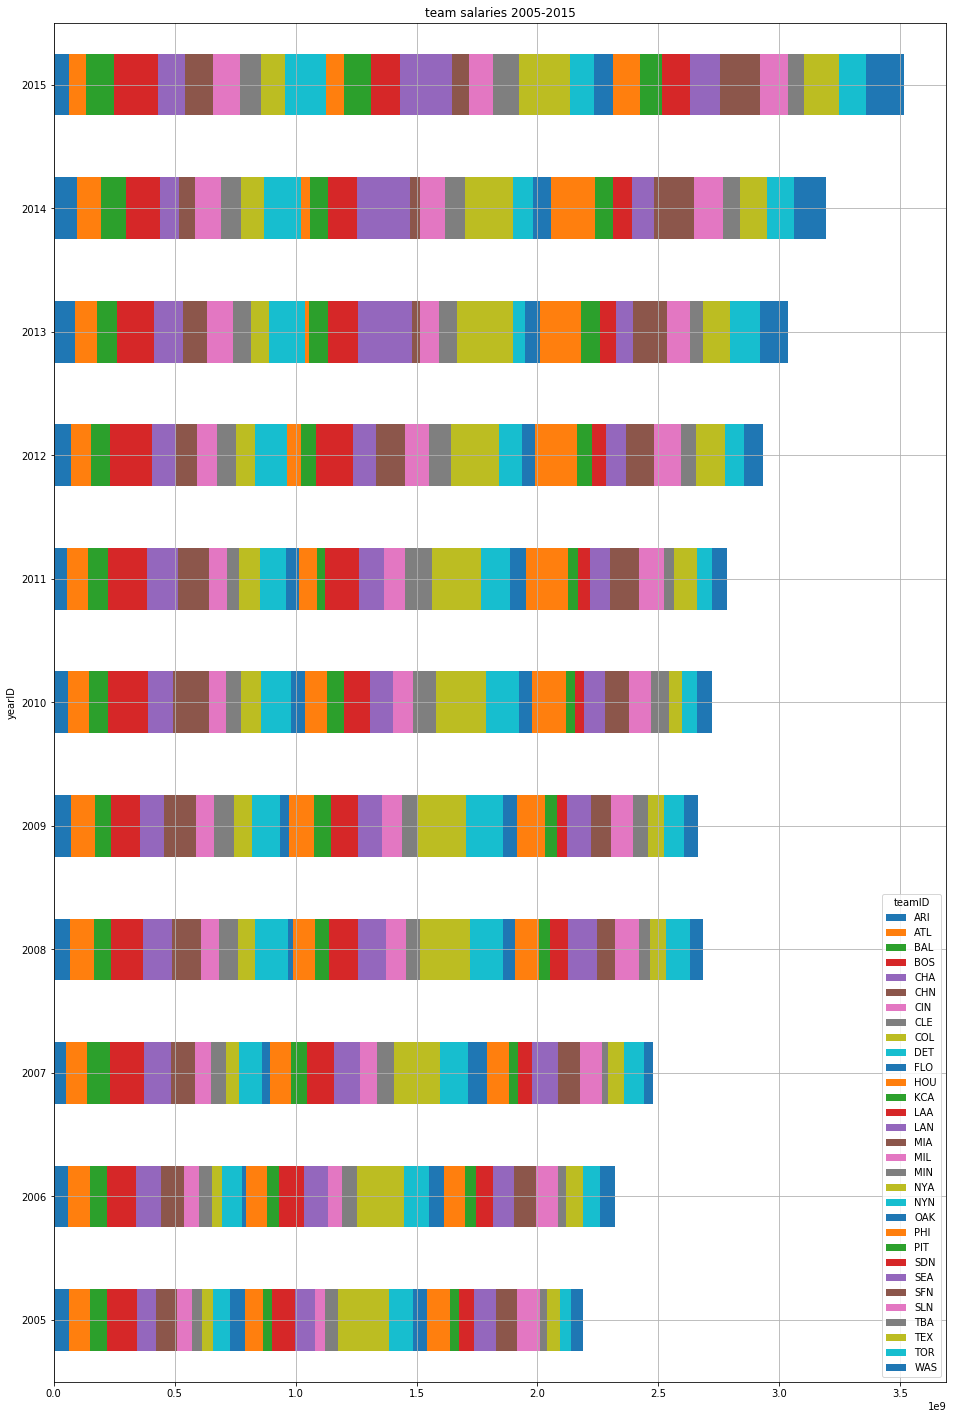

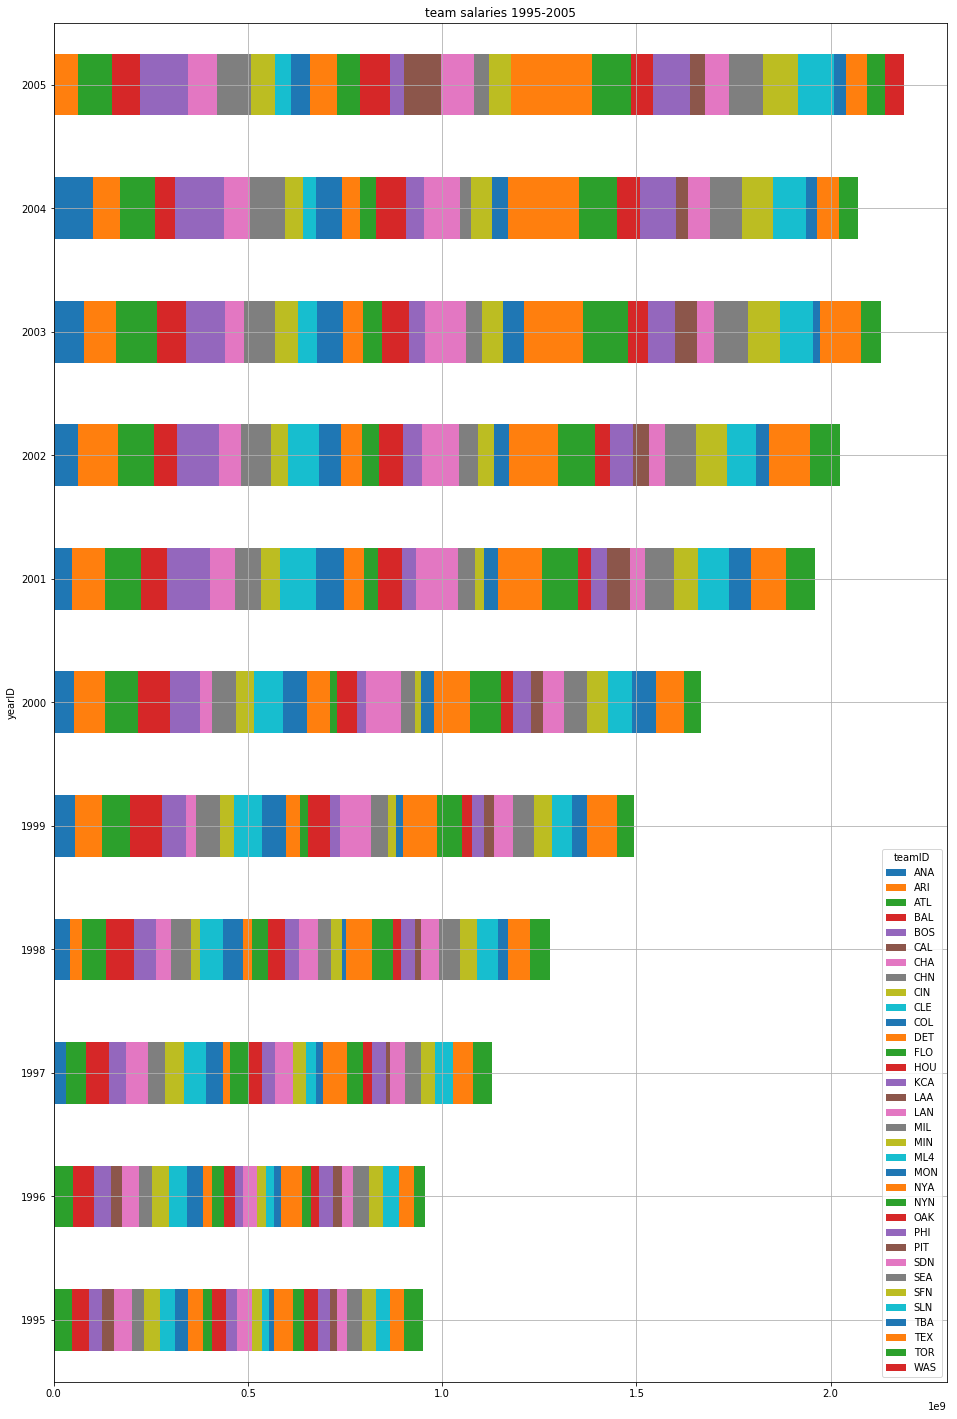

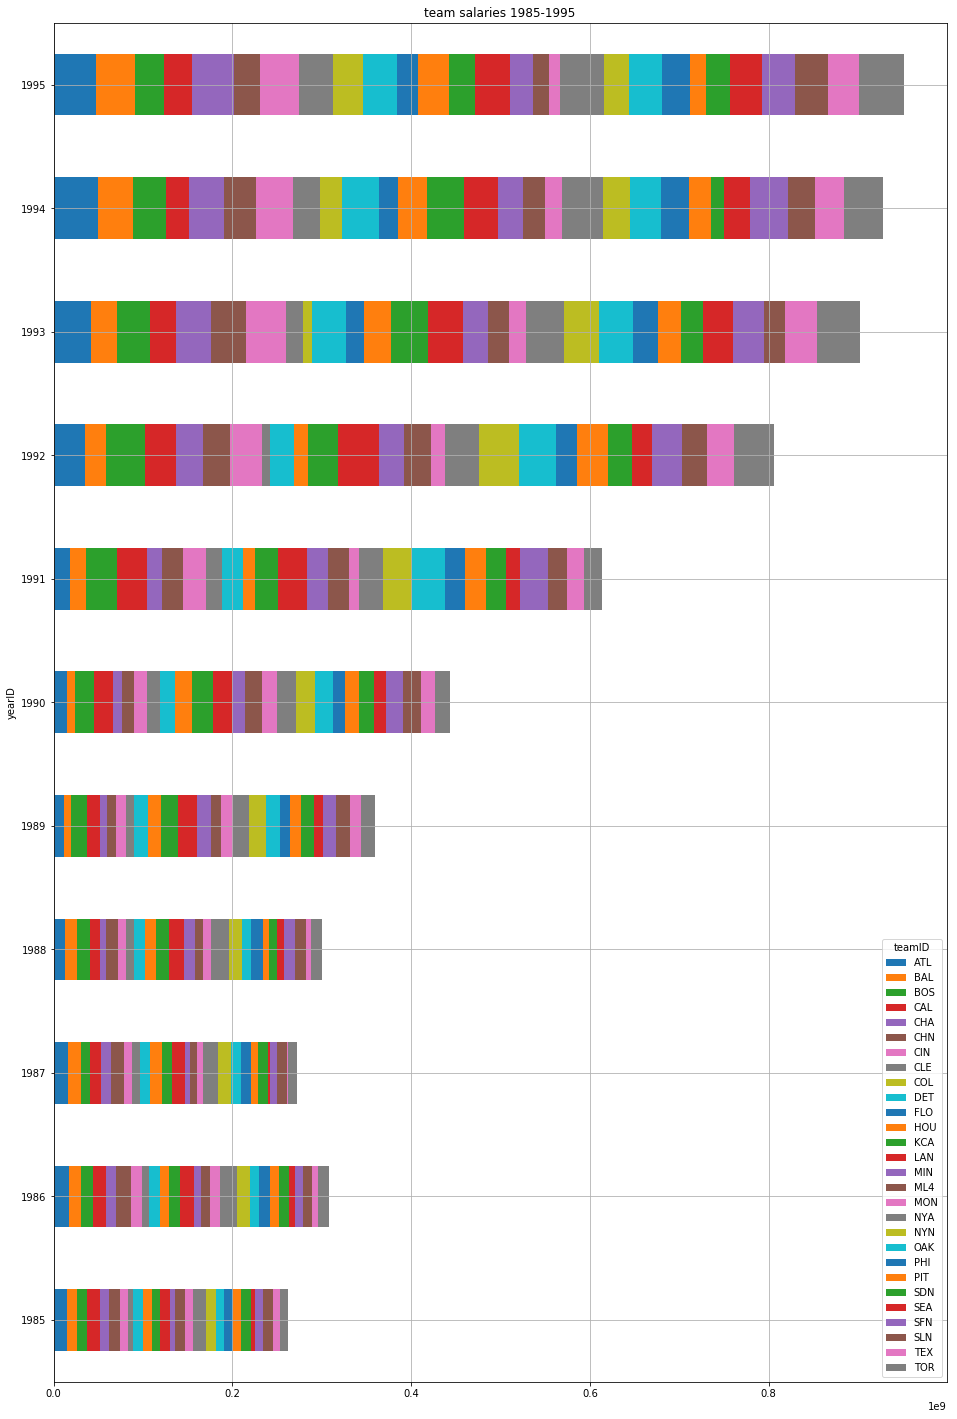

In [20]:
def draw_barh_with_team_salaries(df, title):
    min_year, max_year = get_index_min_max(df, 'yearID')
    title = '%s %d-%d'%(title, min_year, max_year)
    salaries_df = df[['sum']].reset_index()
    draw_df = salaries_df.pivot(index='yearID', columns='teamID', values='sum')
    draw_df.plot.barh(figsize=(16, 25), grid=True, stacked=True, title=title)
    
for df in team_with_salaries_df_10years:
    draw_barh_with_team_salaries(df, 'team salaries')

按年绘制球队总薪资和赛季排名的scatter

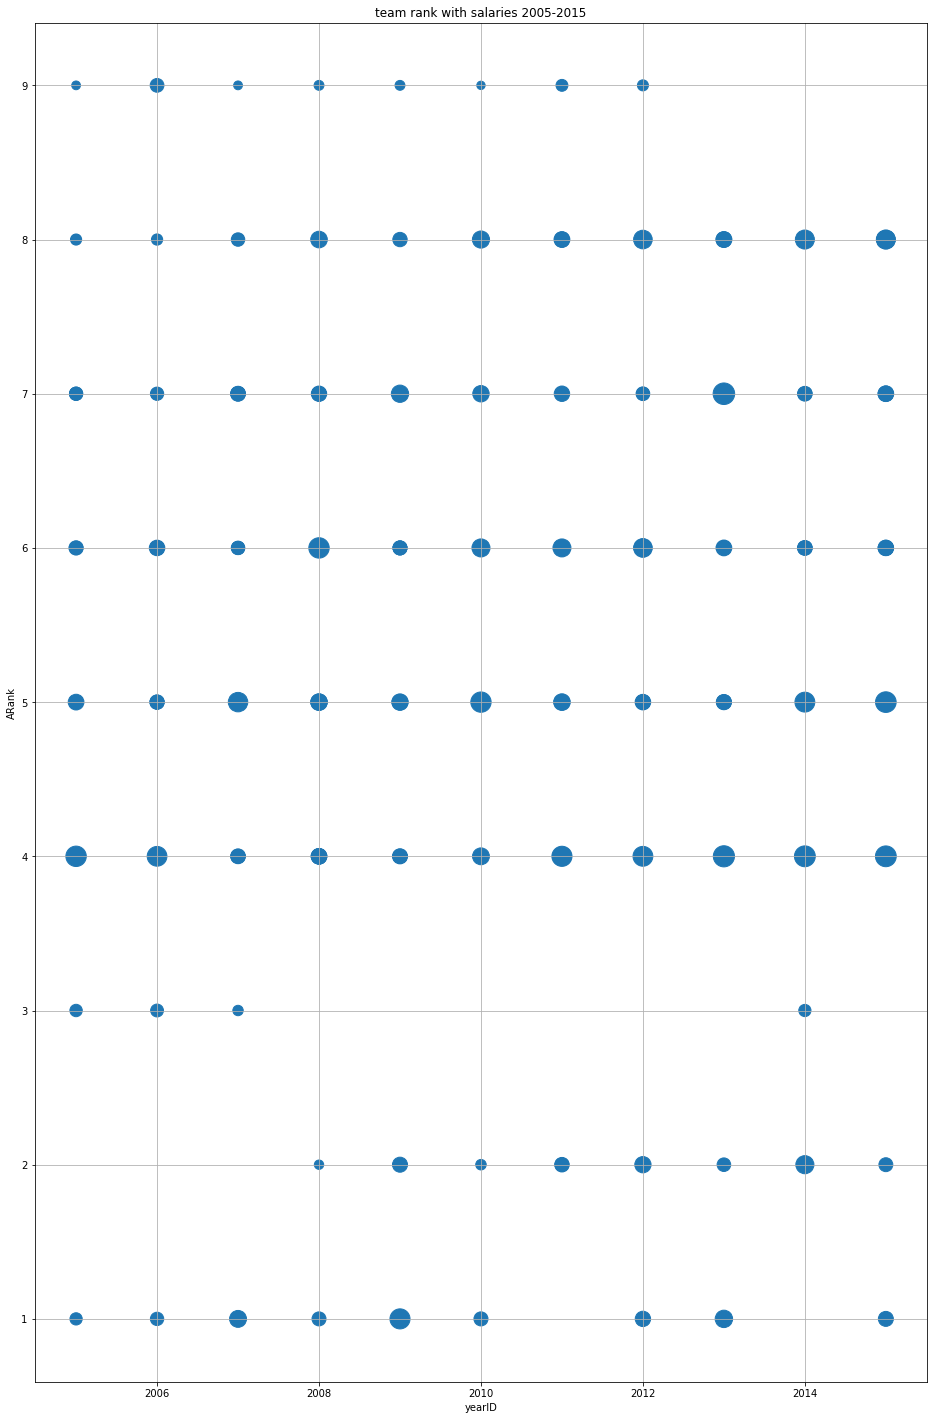

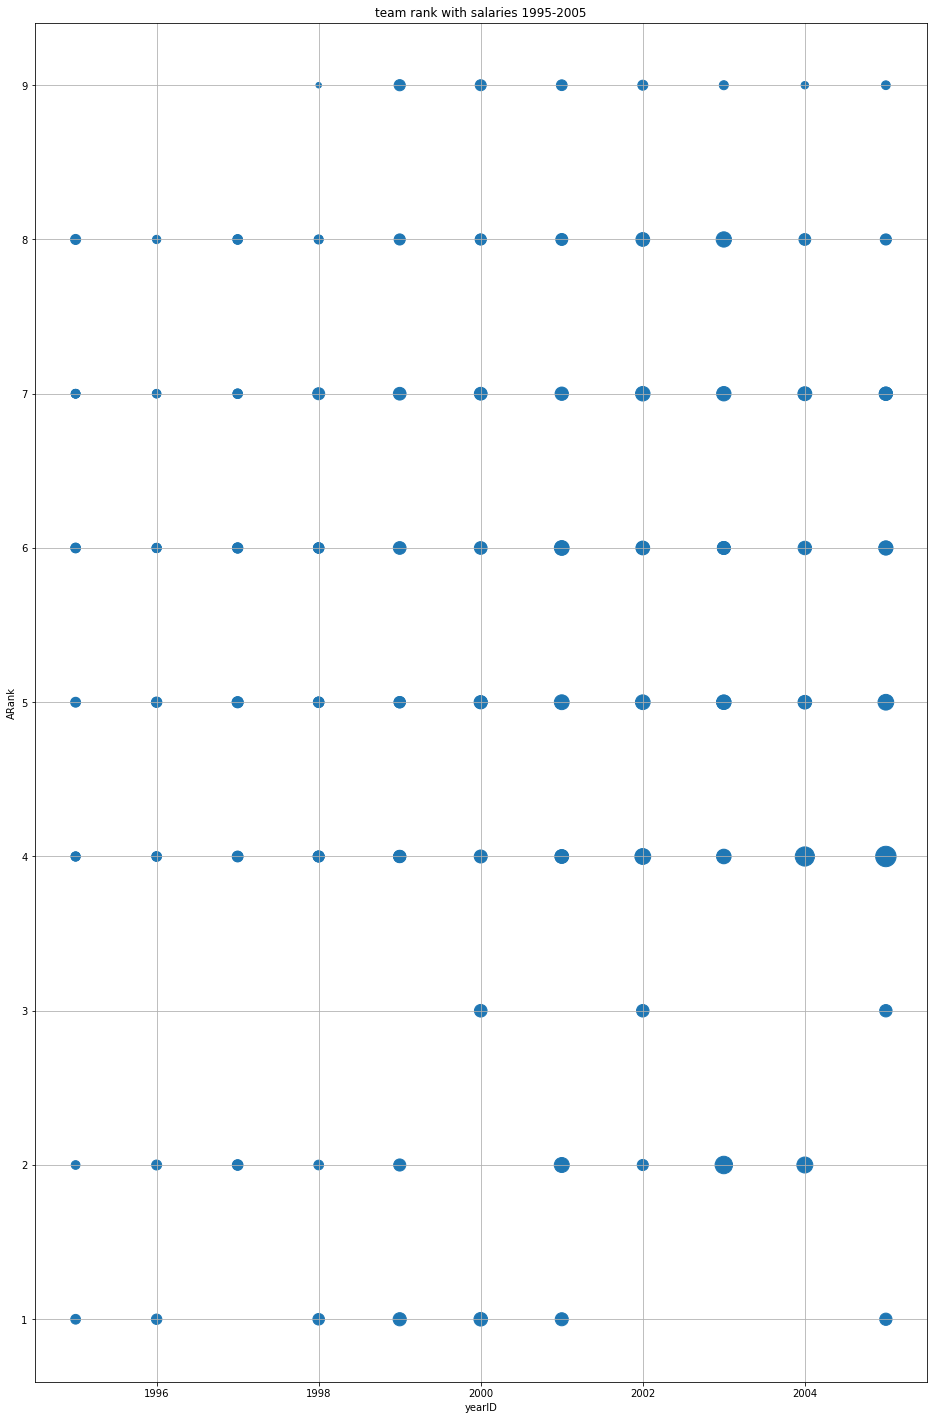

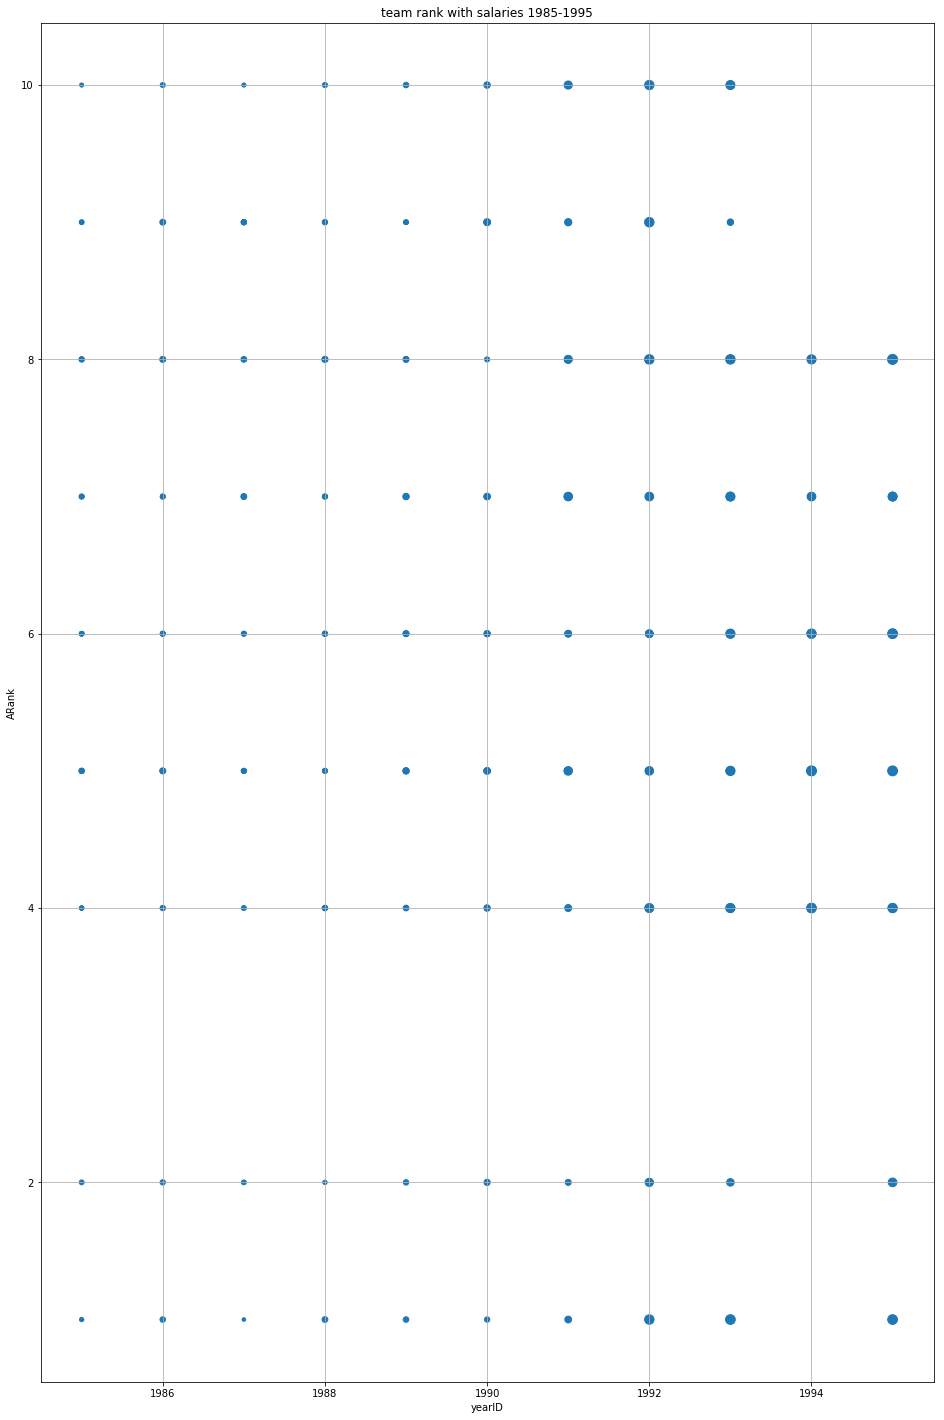

In [21]:
def draw_scatter_with_team_salaries(df, title):
    min_year, max_year = get_index_min_max(df, 'yearID')
    title = '%s %d-%d'%(title, min_year, max_year)
    salaries_df = df[['ARank','sum']].reset_index()
    salaries_df = salaries_df.rename({'sum':'salaries'}, axis='columns')
    
    salaries_df.plot.scatter(x='yearID', y='ARank', s=salaries_df.salaries/500000,
                             figsize=(16, 25), grid=True,
                             title=title)
    
for df in team_with_salaries_df_10years:
    draw_scatter_with_team_salaries(df, 'team rank with salaries')

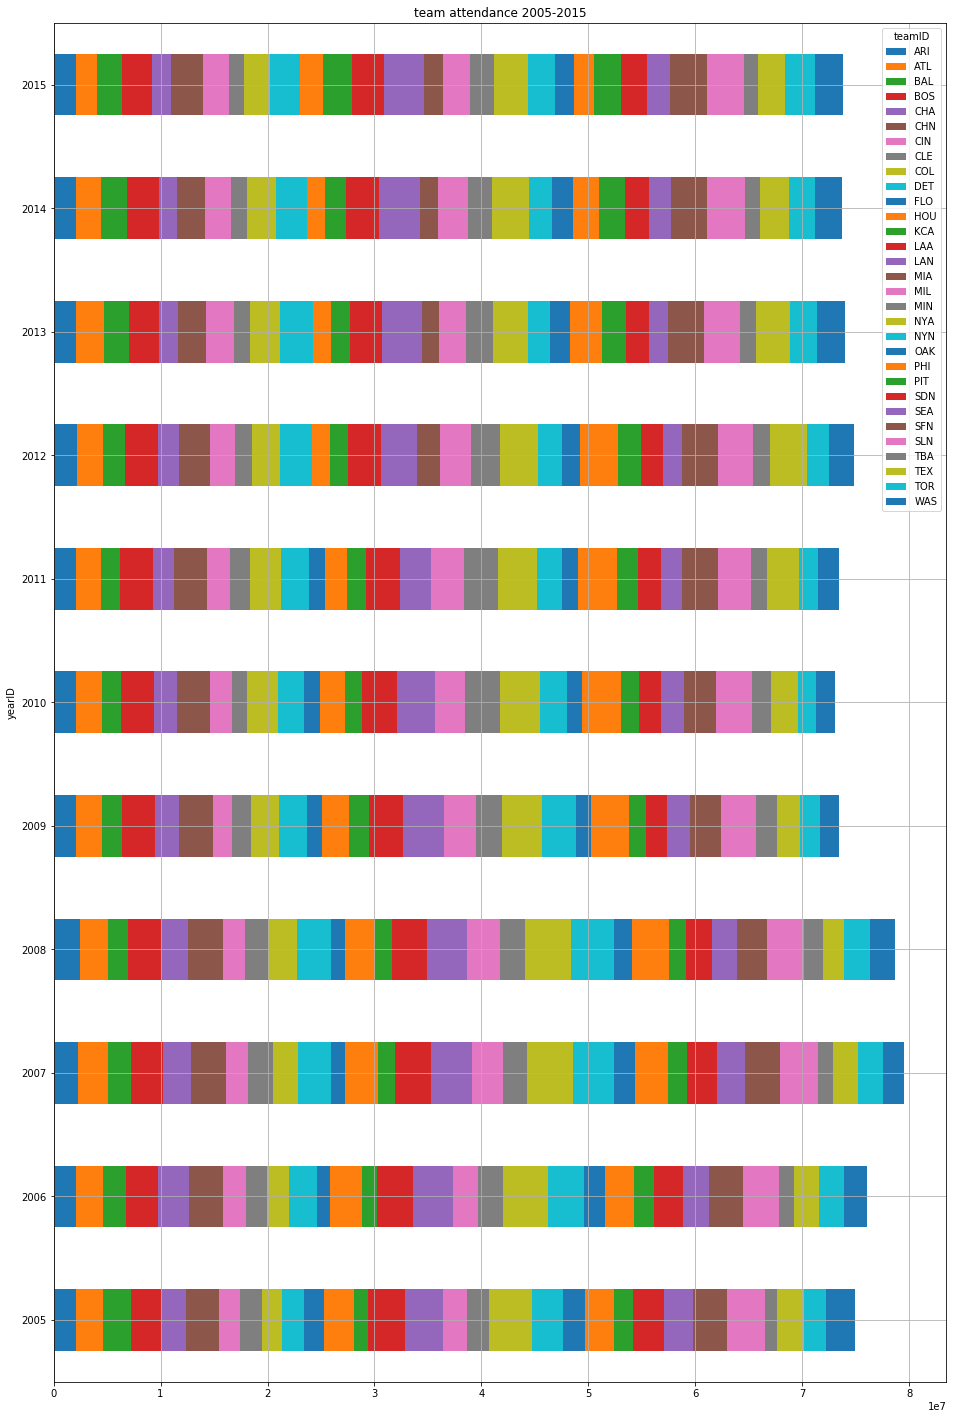

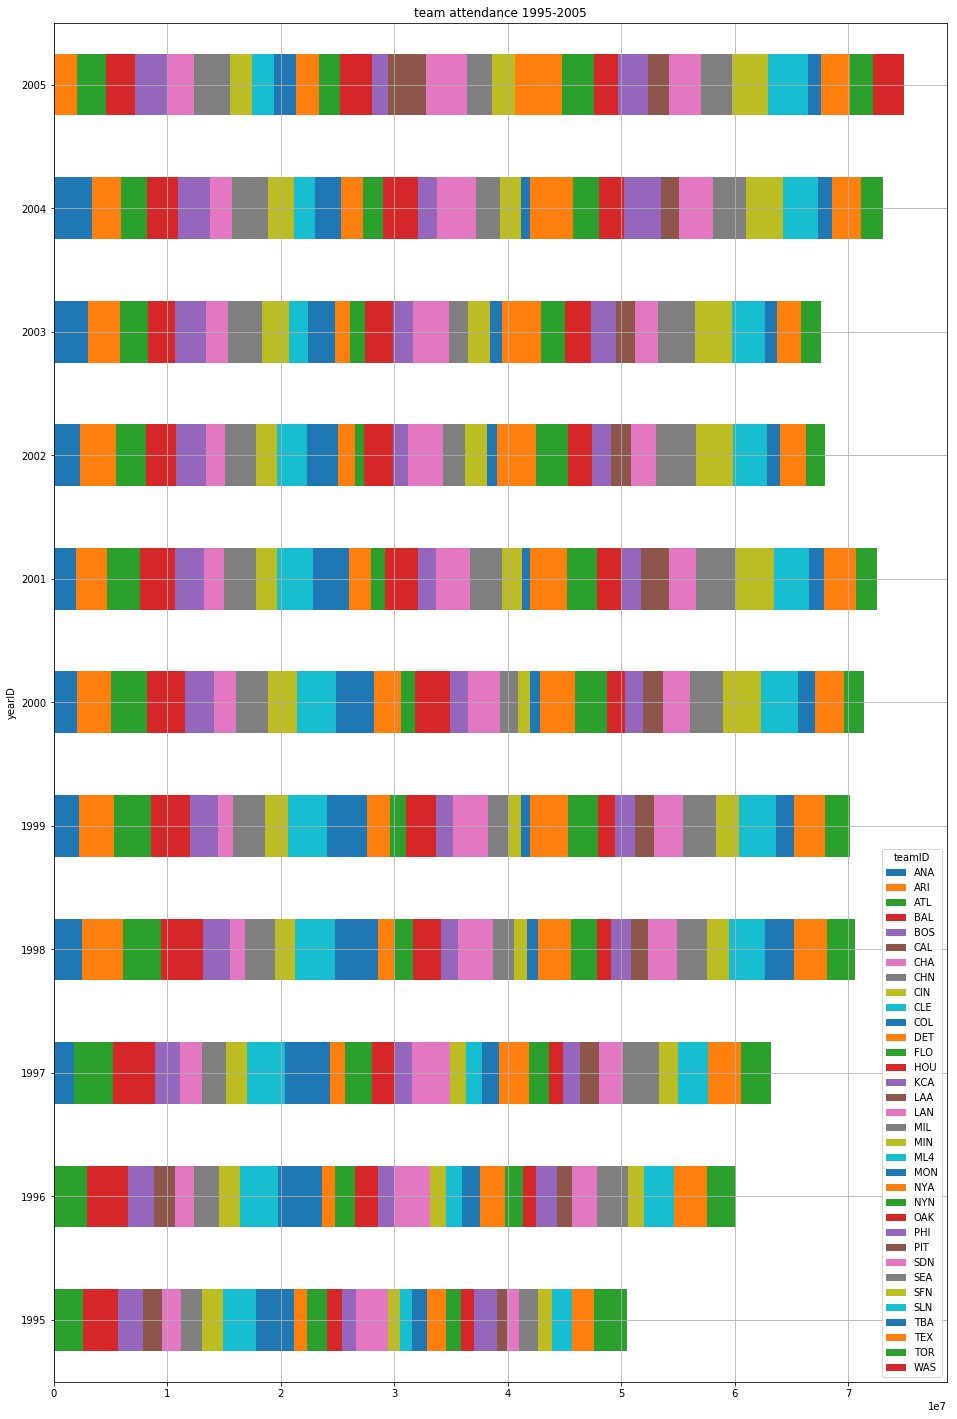

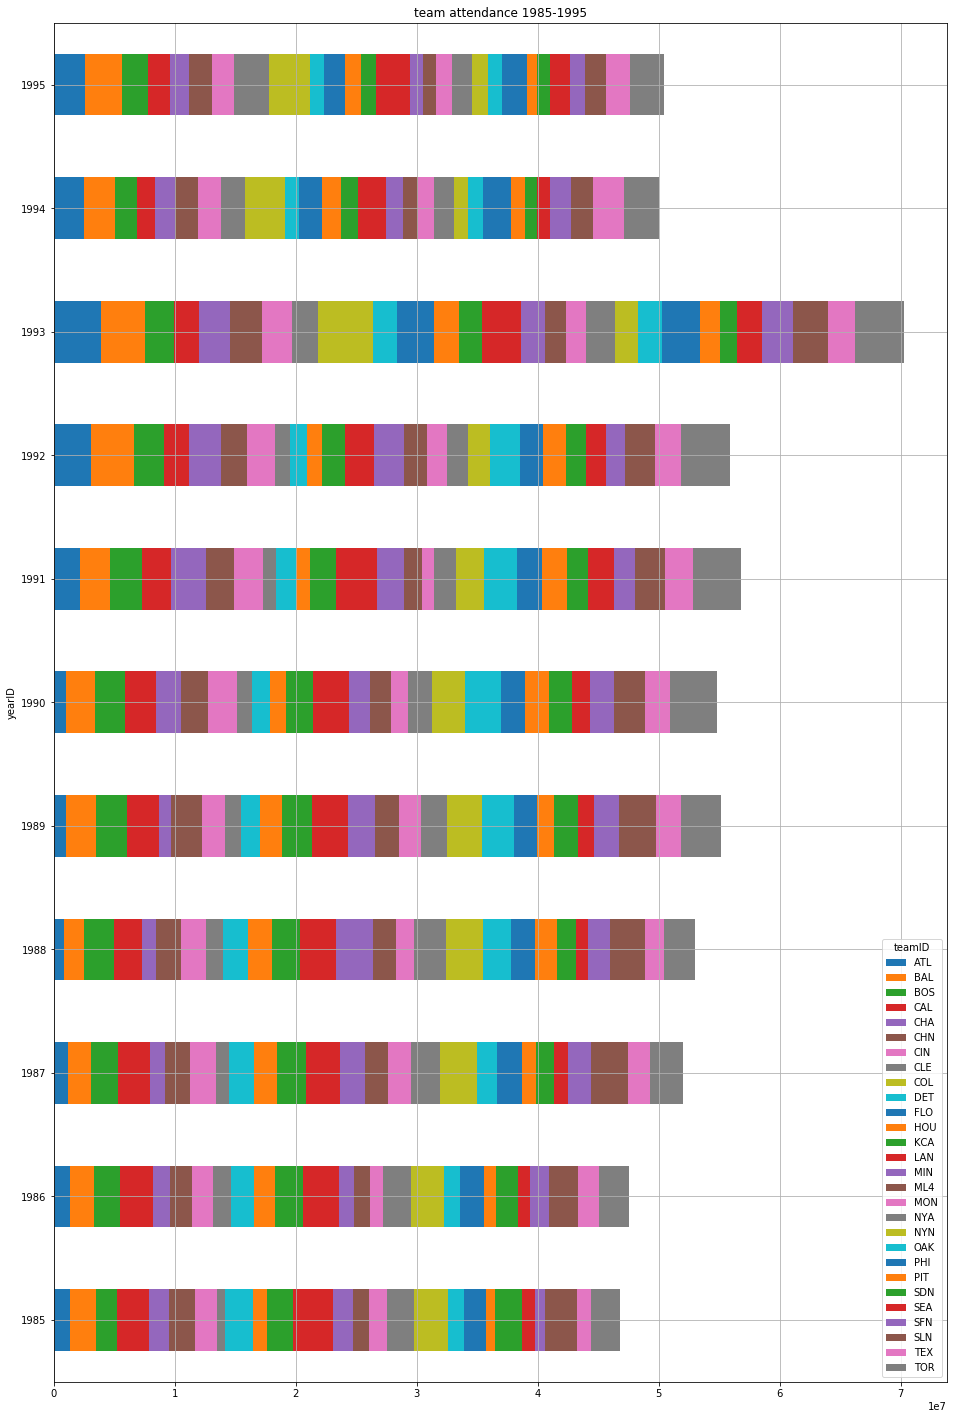

In [22]:
def draw_barh_with_team_attendance(df, title):
    min_year, max_year = get_index_min_max(df, 'yearID')
    title = '%s %d-%d'%(title, min_year, max_year)
    attendances_df = df[['attendance']].reset_index()
    draw_df = attendances_df.pivot(index='yearID', columns='teamID', values='attendance')
    draw_df.plot.barh(figsize=(16, 25), grid=True, stacked=True, title=title)
    
for df in team_with_salaries_df_10years:
    draw_barh_with_team_attendance(df, 'team attendance')

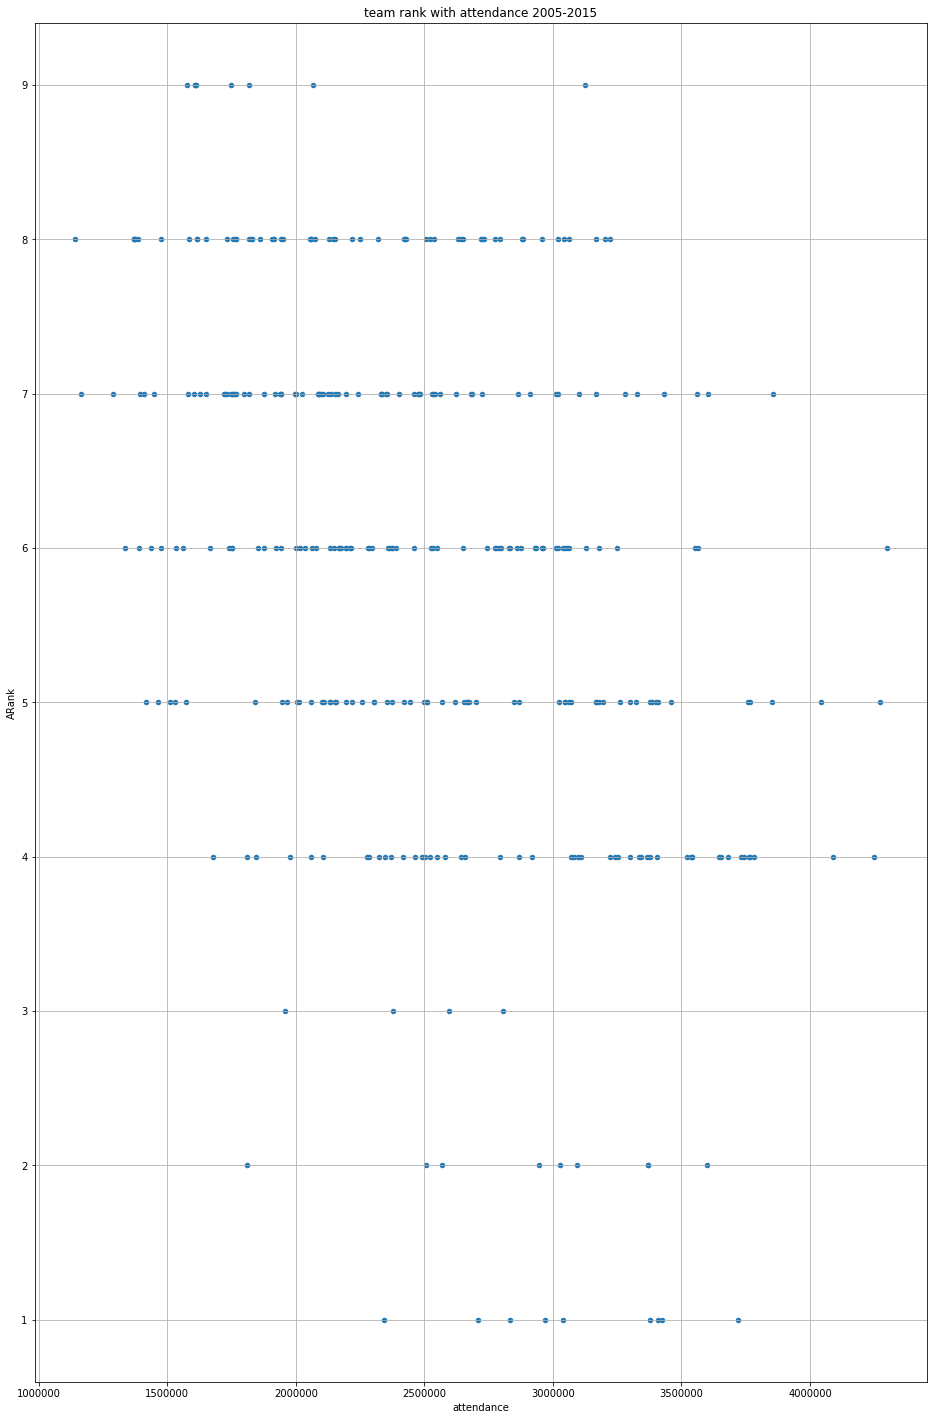

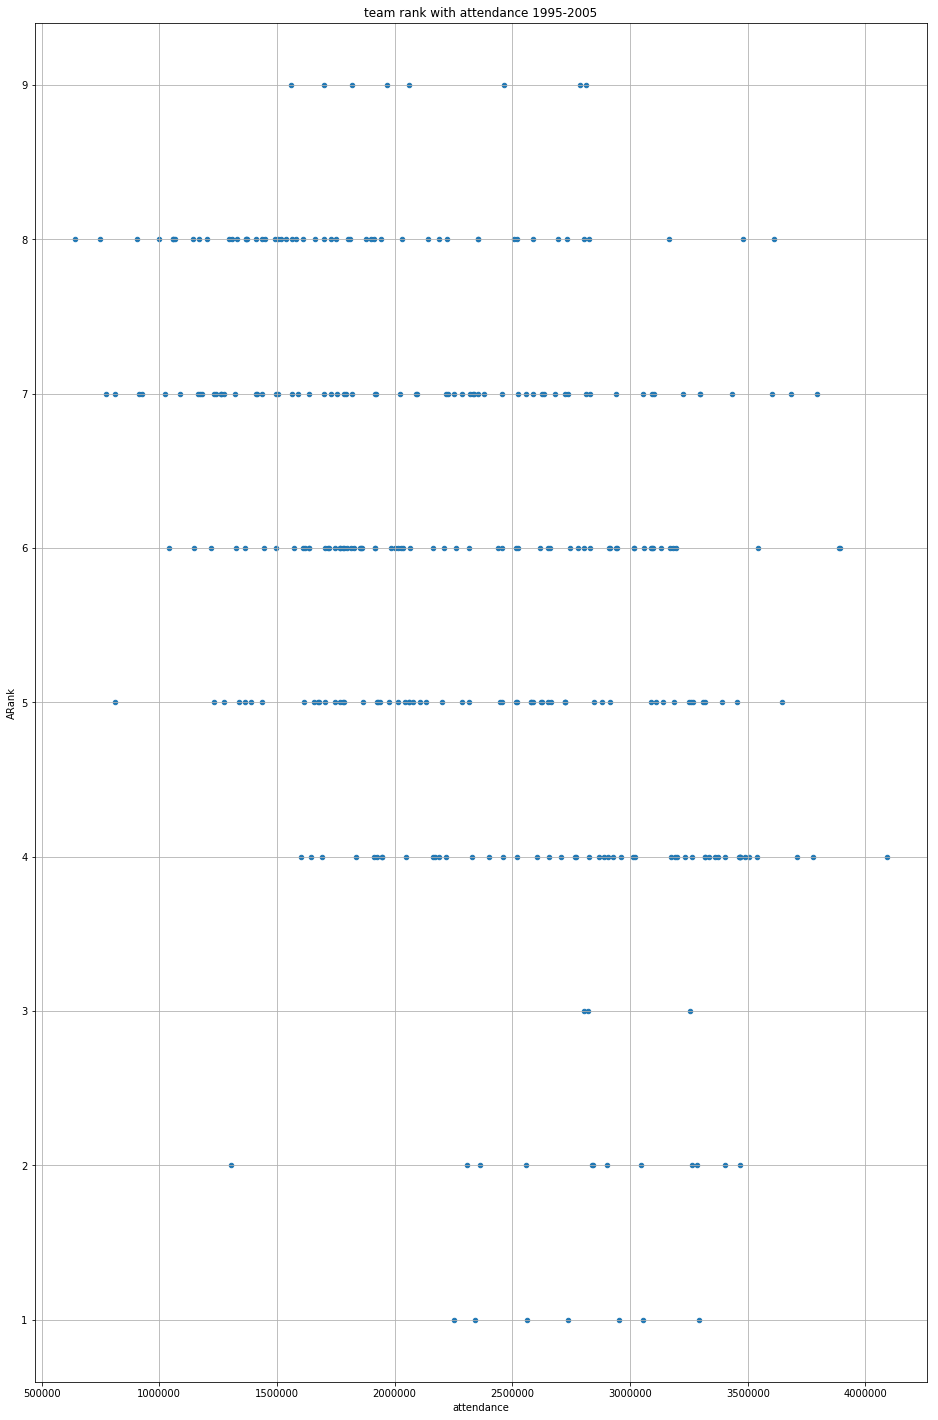

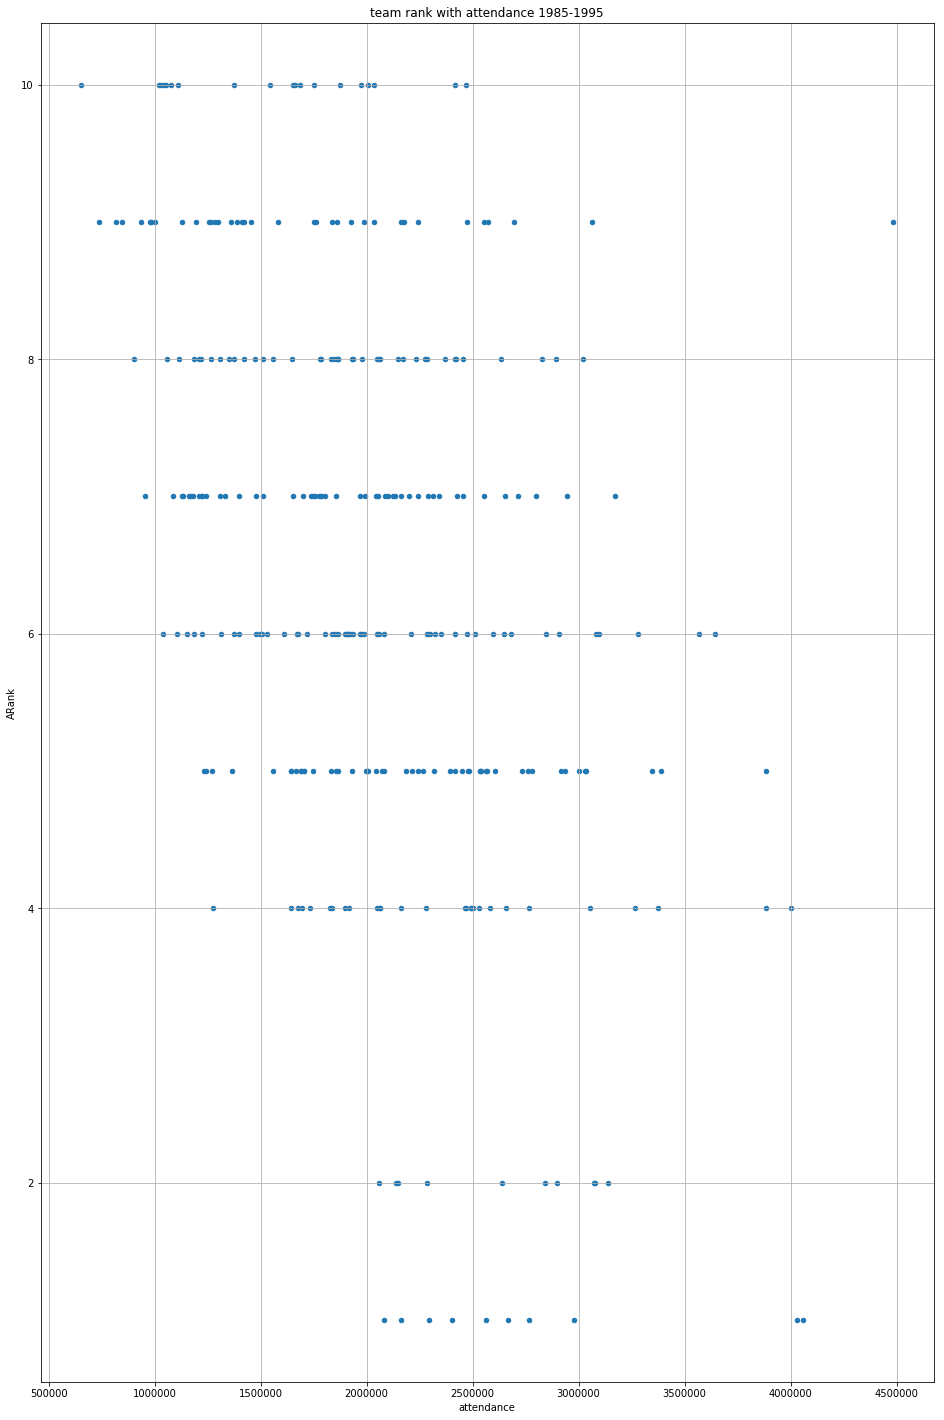

In [23]:
def draw_scatter_with_team_attendance(df, title):
    min_year, max_year = get_index_min_max(df, 'yearID')
    title = '%s %d-%d'%(title, min_year, max_year)
    salaries_df = df[['ARank','attendance']].reset_index()
    
    
    salaries_df.plot.scatter(x='attendance', y='ARank', 
                             figsize=(16, 25), grid=True,
                             title=title)
    
for df in team_with_salaries_df_10years:
    draw_scatter_with_team_attendance(df, 'team rank with attendance')

#### 计算球员数据的相关性

In [24]:
def add_player_birthyear(laries_df, player_df):
    return salaries_df.join(player_df[['birthYear']], on='playerID', how='inner', rsuffix='_p')
    
def calc_player_age_to_salaries_table(salaries_df):
    return salaries_df.apply(lambda row: row['yearID']-row['birthYear'], axis=1)

salaries_df = add_player_birthyear(salaries_df, pd.read_csv('./baseballdatabank-master/core/Master.csv').set_index('playerID'))
salaries_df['age'] = calc_player_age_to_salaries_table(salaries_df)



In [25]:
salaries_df[['birthYear', 'age']] = salaries_df[['birthYear', 'age']].astype('int')
print salaries_df

       yearID teamID lgID   playerID   salary  birthYear  age
0        1985    ATL   NL  barkele01   870000       1955   30
552      1986    ATL   NL  barkele01   880000       1955   31
1291     1987    ATL   NL  barkele01   890000       1955   32
1613     1987    ML4   AL  barkele01    72500       1955   32
1917     1988    ATL   NL  barkele01   900000       1955   33
1        1985    ATL   NL  bedrost01   550000       1957   28
1071     1986    PHI   NL  bedrost01   650000       1957   29
1750     1987    PHI   NL  bedrost01  1050000       1957   30
2374     1988    PHI   NL  bedrost01   925000       1957   31
3069     1989    PHI   NL  bedrost01  1450000       1957   32
4026     1990    SFN   NL  bedrost01  1450000       1957   33
4485     1991    MIN   AL  bedrost01  1350000       1957   34
5611     1993    ATL   NL  bedrost01   500000       1957   36
6534     1994    ATL   NL  bedrost01   750000       1957   37
7418     1995    ATL   NL  bedrost01   750000       1957   38
2       

显示某个赛季球员薪资的分布，y以10为刻度，分为30个桶

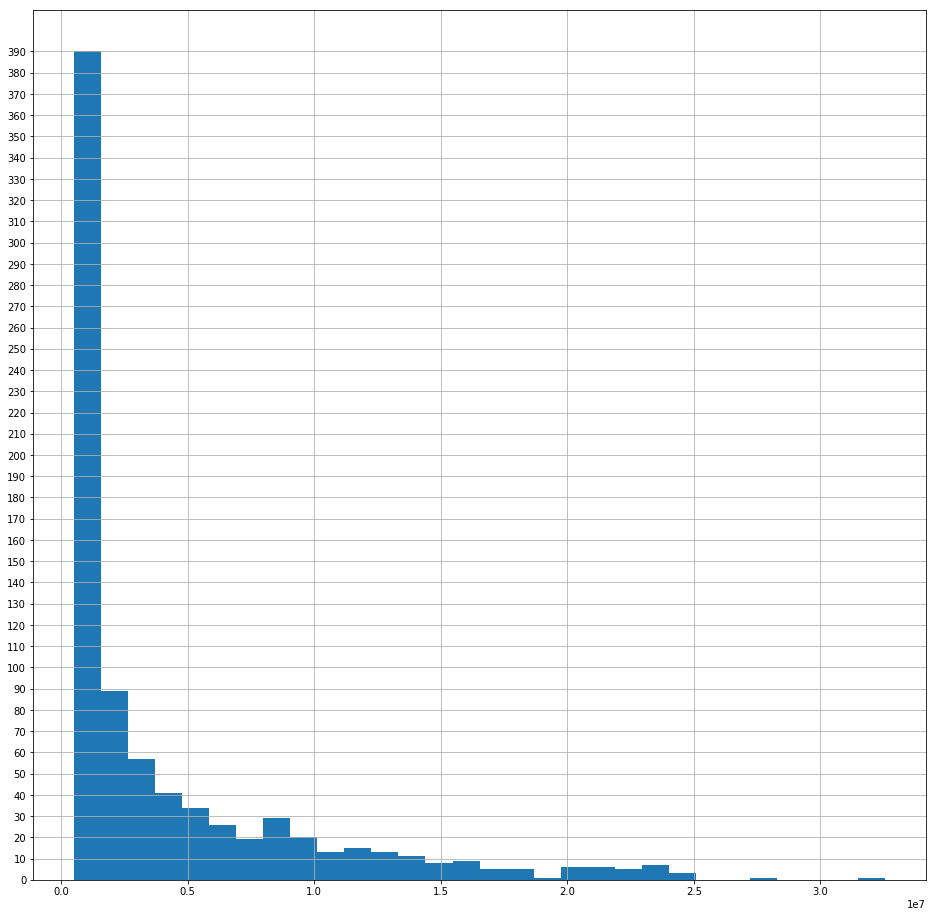

In [76]:
ax = year_salaries_df.loc[2015].salary.hist(bins=30, figsize=(16, 16))
ax.set_yticks(range(0, 400, 10))

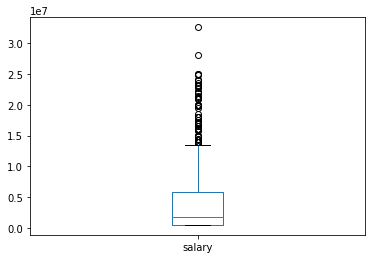

In [77]:
ax = year_salaries_df.loc[2015].salary.plot.box()

In [90]:
def salary_club_great_than(year_salaries_df, yearID, salary):
    df1 = year_salaries_df.loc[yearID]
    df2 = df1.salary.loc[lambda s: s >= salary]
    return df2.shape[0]

def salary_club_great_than_10m(year_salaries_df, yearID):
    return salary_club_great_than(year_salaries_df, yearID, 10000000)

def salary_club_great_than_20m(year_salaries_df, yearID):
    return salary_club_great_than(year_salaries_df, yearID, 20000000)



120
27


In [96]:
print salary_club_great_than_10m(year_salaries_df, 2015)
print salary_club_great_than_20m(year_salaries_df, 2015)
print salary_club_great_than_10m(year_salaries_df, 2010)
print salary_club_great_than_20m(year_salaries_df, 2010)

120
27
82
6


计算场均BATTING数据(考虑赛季中转会的因素）
* G              Games
* AB             At Bats
* R              Runs
* H              Hits
* 2B             Doubles
* 3B             Triples
* HR             Homeruns
* RBI            Runs Batted In
* SB             Stolen Bases
* CS             Caught Stealing
* BB             Base on Balls
* SO             Strikeouts
* IBB            Intentional walks
* HBP            Hit by pitch
* SH             Sacrifice hits
* SF             Sacrifice flies
* GIDP           Grounded into double plays


In [26]:
batting_df = pd.read_csv('./baseballdatabank-master/core/Batting.csv')
batting_df = batting_df[batting_df['yearID']>=START_YEAR].set_index(['playerID', 'yearID', 'teamID']).groupby(['playerID', 'yearID']).sum()
#batting_df = batting_df.set_index(['playerID', 'yearID', 'teamID'])
print batting_df

                  stint    G     AB     R      H    2B   3B    HR   RBI   SB  \
playerID  yearID                                                               
aardsda01 2004        1   11    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2006        1   45    2.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2007        1   25    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2008        1   47    1.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2009        1   73    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2010        1   53    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2012        1    1    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2013        1   43    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2015        1   33    1.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
aasedo01  1985        1   54    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          1986        1   66    0.0   0.

In [27]:

def gameavg_batting(row):
    result = {}
    games = row['G']
    if games == 0:
        games = 1
    result['gab_ab'] = row['AB']/games
    result['gab_h'] = row['H']/games
    result['gab_2b'] = row['2B']/games
    result['gab_3b'] = row['3B']/games
    result['gab_hr'] = row['HR']/games
    result['gab_rbi'] = row['RBI']/games
    result['gab_sb'] = row['SB']/games
    result['gab_cs'] = row['CS']/games
    result['gab_bb'] = row['3B']/games
    result['gab_so'] = row['SO']/games
    result['gab_ibb'] = row['IBB']/games
    result['gab_hbp'] = row['HBP']/games
    result['gab_sh'] = row['SH']/games
    result['gab_sf'] = row['SF']/games
    result['gab_gidp'] = row['GIDP']/games
    return pd.Series(result)
ga_batting_df = batting_df.merge(batting_df.apply(lambda row: gameavg_batting(row), axis=1),
                 left_index=True, right_index=True,
                 validate='1:1')
#batting_df[['result['gab_ab','gab_h','gab_2b','gab_3b','gab_hr','gab_rbi','gab_sb','gab_cs','gab_bb','gab_so','gab_ibb','gab_hbp','gab_sh','gab_sf','gab_gidp']]'] = batting_df.apply(lambda row: gameavg_batting(row), axis=1)
print ga_batting_df

                  stint    G     AB     R      H    2B   3B    HR   RBI   SB  \
playerID  yearID                                                               
aardsda01 2004        1   11    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2006        1   45    2.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2007        1   25    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2008        1   47    1.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2009        1   73    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2010        1   53    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2012        1    1    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2013        1   43    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          2015        1   33    1.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
aasedo01  1985        1   54    0.0   0.0    0.0   0.0  0.0   0.0   0.0  0.0   
          1986        1   66    0.0   0.

计算场均投球数据(考虑赛季中转会的因素）
* W              Wins
* L              Losses
* G              Games
* GS             Games Started
* CG             Complete Games 
* SHO            Shutouts
* SV             Saves
* IPOuts         Outs Pitched (innings pitched x 3)
* H              Hits
* ER             Earned Runs
* HR             Homeruns
* BB             Walks
* SO             Strikeouts
* BAOpp          Opponent's Batting Average
* ERA            Earned Run Average
* IBB            Intentional Walks
* WP             Wild Pitches
* HBP            Batters Hit By Pitch
* BK             Balks
* BFP            Batters faced by Pitcher
* GF             Games Finished
* R              Runs Allowed
* SH             Sacrifices by opposing batters
* SF             Sacrifice flies by opposing batters
* GIDP           Grounded into double plays by opposing batter



In [28]:
pitching_df = pd.read_csv('./baseballdatabank-master/core/Pitching.csv')
pitching_df = pitching_df[pitching_df['yearID']>=START_YEAR].set_index(['playerID', 'yearID', 'teamID']).groupby(['playerID', 'yearID']).sum()
print pitching_df

                  stint   W   L   G  GS  CG  SHO  SV  IPouts    H  ...    IBB  \
playerID  yearID                                                   ...          
aardsda01 2004        1   1   0  11   0   0    0   0    32.0   20  ...    0.0   
          2006        1   3   0  45   0   0    0   0   159.0   41  ...    0.0   
          2007        1   2   1  25   0   0    0   0    97.0   39  ...    3.0   
          2008        1   4   2  47   0   0    0   0   146.0   49  ...    2.0   
          2009        1   3   6  73   0   0    0  38   214.0   49  ...    3.0   
          2010        1   0   6  53   0   0    0  31   149.0   33  ...    5.0   
          2012        1   0   0   1   0   0    0   0     3.0    1  ...    0.0   
          2013        1   2   2  43   0   0    0   0   119.0   39  ...    6.0   
          2015        1   1   1  33   0   0    0   0    92.0   25  ...    3.0   
aasedo01  1985        1  10   6  54   0   0    0  14   264.0   83  ...    7.0   
          1986        1   6 

In [29]:

def gameavg_pitching(row):
    result = {}
    games = row['G']
    if games == 0:
        games = 1
    result['gap_wins'] = row['W']
    result['gap_losses'] = row['L']
    result['gap_games'] = games
    result['gap_started'] = row['GS']
    result['gap_completed'] = row['CG']
    result['gap_sho'] = row['SHO']/games
    result['gap_sv'] = row['SV']/games
    result['gap_ipouts'] = row['IPouts']/games
    result['gap_h'] = row['H']/games
    result['gap_hr'] = row['HR']/games
    result['gap_bb'] = row['BB']/games
    result['gap_so'] = row['SO']/games
    result['gap_baopp'] = row['BAOpp']/games
    result['gap_era'] = row['ERA']/games
    result['gap_ibb'] = row['IBB']/games
    result['gap_wp'] = row['WP']/games
    result['gap_hbp'] = row['HBP']/games
    result['gap_bk'] = row['BK']/games
    result['gap_bfp'] = row['BFP']/games
    result['gap_gf'] = row['GF']/games
    result['gap_r'] = row['R']/games
    result['gap_sh'] = row['SH']/games
    result['gap_sf'] = row['SF']/games
    result['gap_gidp'] = row['GIDP']/games
    return pd.Series(result)

ga_pitching_df = pitching_df.merge(pitching_df.apply(lambda row: gameavg_pitching(row), axis=1),
                  left_index=True, right_index=True,
                  validate='1:1')
print ga_pitching_df

                  stint   W   L   G  GS  CG  SHO  SV  IPouts    H    ...     \
playerID  yearID                                                     ...      
aardsda01 2004        1   1   0  11   0   0    0   0    32.0   20    ...      
          2006        1   3   0  45   0   0    0   0   159.0   41    ...      
          2007        1   2   1  25   0   0    0   0    97.0   39    ...      
          2008        1   4   2  47   0   0    0   0   146.0   49    ...      
          2009        1   3   6  73   0   0    0  38   214.0   49    ...      
          2010        1   0   6  53   0   0    0  31   149.0   33    ...      
          2012        1   0   0   1   0   0    0   0     3.0    1    ...      
          2013        1   2   2  43   0   0    0   0   119.0   39    ...      
          2015        1   1   1  33   0   0    0   0    92.0   25    ...      
aasedo01  1985        1  10   6  54   0   0    0  14   264.0   83    ...      
          1986        1   6   7  66   0   0    0  34

 读取 fielding 数据(考虑赛季中转会的因素）
 
 * Pos            Position
 * G              Games 
 * GS             Games Started
 * InnOuts        Time played in the field expressed as outs 
 * PO             Putouts
 * A              Assists
 * E              Errors
 * DP             Double Plays
 * PB             Passed Balls (by catchers)
 * WP             Wild Pitches (by catchers)
 * SB             Opponent Stolen Bases (by catchers)
 * CS             Opponents Caught Stealing (by catchers)
 * ZR             Zone Rating

In [30]:
fielding_df_orig = pd.read_csv('./baseballdatabank-master/core/Fielding.csv')
fielding_df = fielding_df_orig[fielding_df_orig['yearID']>=START_YEAR].set_index(['playerID', 'yearID', 'teamID']).groupby(['playerID', 'yearID']).sum()
print fielding_df

                  stint    G     GS  InnOuts      PO      A     E    DP   PB  \
playerID  yearID                                                               
aardsda01 2004        1   11    0.0     33.0     0.0    0.0   0.0   0.0  0.0   
          2006        1   45    0.0    159.0     1.0    5.0   0.0   1.0  0.0   
          2007        1   25    0.0     96.0     2.0    4.0   1.0   0.0  0.0   
          2008        1   47    0.0    147.0     3.0    6.0   0.0   0.0  0.0   
          2009        1   73    0.0    213.0     2.0    5.0   0.0   1.0  0.0   
          2010        1   53    0.0    150.0     2.0    3.0   1.0   0.0  0.0   
          2012        1    1    0.0      3.0     0.0    0.0   0.0   0.0  0.0   
          2013        1   43    0.0    120.0     1.0    5.0   0.0   0.0  0.0   
          2015        1   33    0.0      0.0     0.0    1.0   1.0   0.0  0.0   
aasedo01  1985        1   54    0.0    264.0     8.0   10.0   0.0   0.0  0.0   
          1986        1   66    0.0    2

In [31]:
def gameavg_fielding(row):
    result = {}
    games = row['G']
    if games == 0:
        games = 1
    #result['gap_pos'] = row['POS']
    result['gap_games'] = games
    result['gap_started'] = row['GS']
    result['gap_innouts'] = row['InnOuts']/games
    result['gap_po'] = row['PO']/games
    result['gap_a'] = row['A']/games
    result['gap_e'] = row['E']/games
    result['gap_dp'] = row['DP']/games
    result['gap_pb'] = row['PB']/games
    result['gap_wp'] = row['WP']/games
    result['gap_sb'] = row['SB']/games
    result['gap_cs'] = row['CS']/games
    result['gap_zr'] = row['ZR']/games
    return pd.Series(result)

ga_fielding_df = fielding_df.merge(fielding_df.apply(lambda row: gameavg_fielding(row), axis=1),
                  left_index=True, right_index=True,
                  validate='1:1')

print ga_fielding_df

                  stint    G     GS  InnOuts      PO      A     E    DP   PB  \
playerID  yearID                                                               
aardsda01 2004        1   11    0.0     33.0     0.0    0.0   0.0   0.0  0.0   
          2006        1   45    0.0    159.0     1.0    5.0   0.0   1.0  0.0   
          2007        1   25    0.0     96.0     2.0    4.0   1.0   0.0  0.0   
          2008        1   47    0.0    147.0     3.0    6.0   0.0   0.0  0.0   
          2009        1   73    0.0    213.0     2.0    5.0   0.0   1.0  0.0   
          2010        1   53    0.0    150.0     2.0    3.0   1.0   0.0  0.0   
          2012        1    1    0.0      3.0     0.0    0.0   0.0   0.0  0.0   
          2013        1   43    0.0    120.0     1.0    5.0   0.0   0.0  0.0   
          2015        1   33    0.0      0.0     0.0    1.0   1.0   0.0  0.0   
aasedo01  1985        1   54    0.0    264.0     8.0   10.0   0.0   0.0  0.0   
          1986        1   66    0.0    2

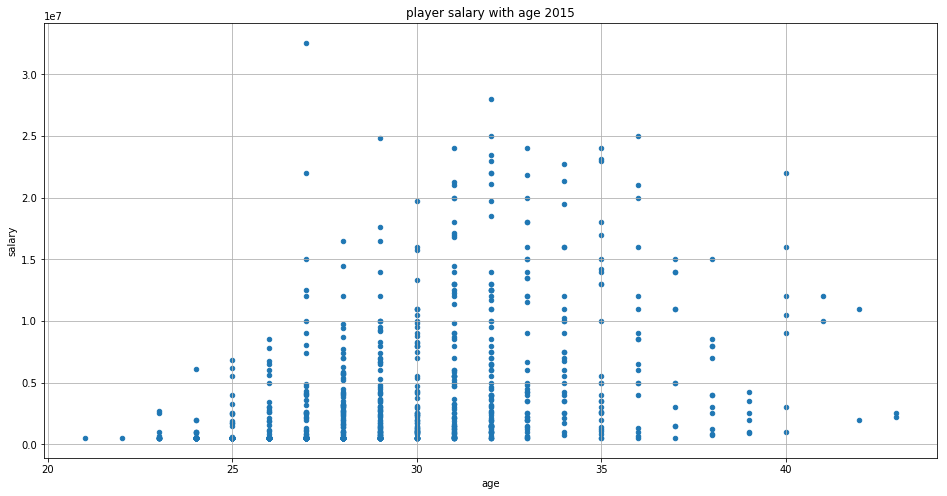

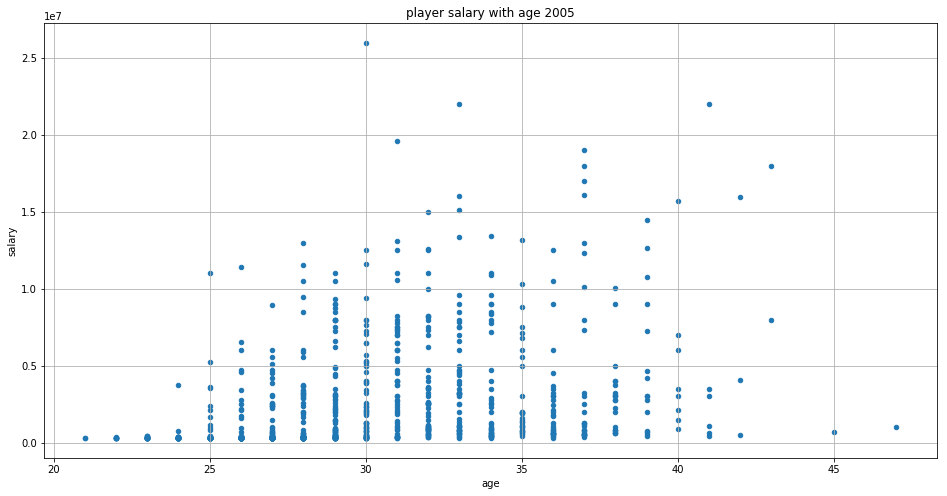

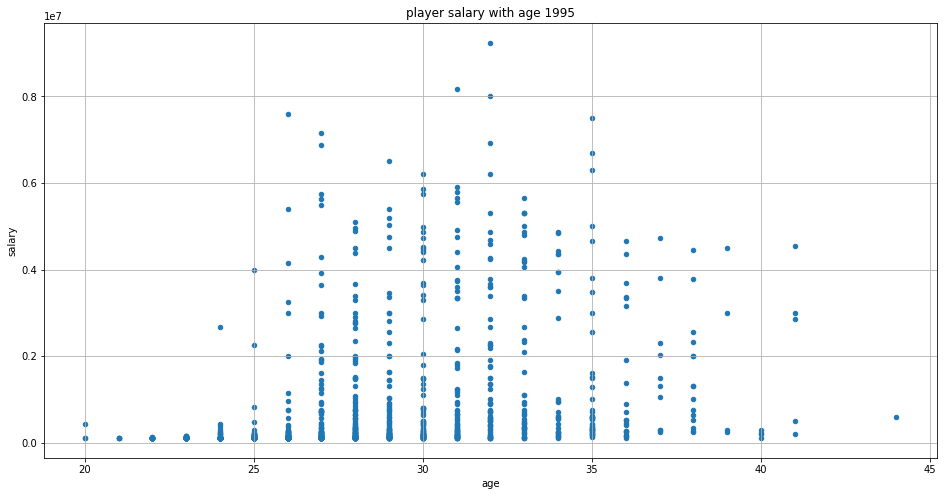

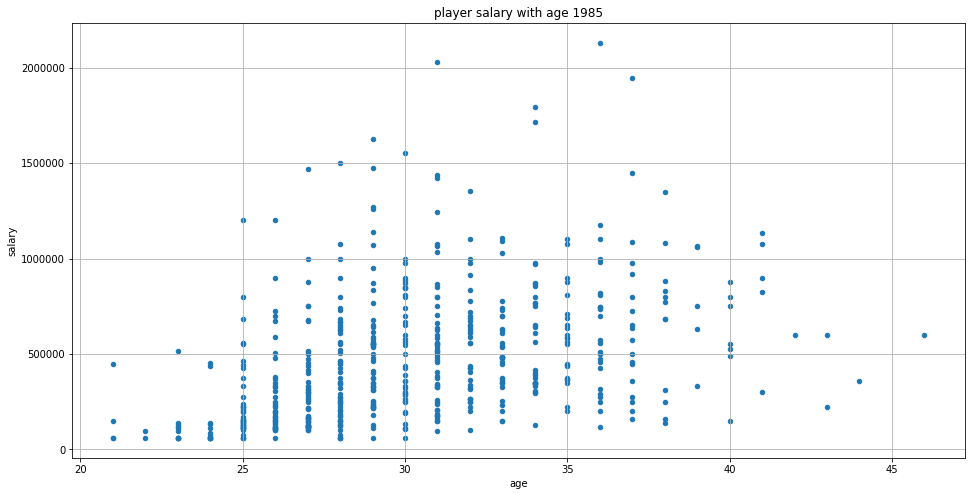

In [32]:
year_salaries_df = salaries_df.set_index('yearID')
def draw_age_sal_plot(df, yearID):
    year_df = df.loc[yearID][['age', 'salary']]    
    title = 'player salary with age ' + str(yearID)
    year_df.plot.scatter(x='age', y='salary', 
                             figsize=(16, 8), grid=True,
                        title = title)

draw_age_sal_plot(year_salaries_df, 2015)
draw_age_sal_plot(year_salaries_df, 2005)
draw_age_sal_plot(year_salaries_df, 1995)
draw_age_sal_plot(year_salaries_df, 1985)

计算球员出场数据
Appearances table:

  * `G_all` int(11) DEFAULT NULL,
  * `GS` varchar(255) DEFAULT NULL,
  * `G_batting` int(11) DEFAULT NULL,
  * `G_defense` int(11) DEFAULT NULL,
  * `G_p` int(11) DEFAULT NULL,
  * `G_c` int(11) DEFAULT NULL,
  * `G_1b` int(11) DEFAULT NULL,
  * `G_2b` int(11) DEFAULT NULL,
  * `G_3b` int(11) DEFAULT NULL,
  * `G_ss` int(11) DEFAULT NULL,
  * `G_lf` int(11) DEFAULT NULL,
  * `G_cf` int(11) DEFAULT NULL,
  * `G_rf` int(11) DEFAULT NULL,
  * `G_of` int(11) DEFAULT NULL,
  * `G_dh` varchar(255) DEFAULT NULL,
  * `G_ph` varchar(255) DEFAULT NULL,
  * `G_pr` varchar(255) DEFAULT NULL


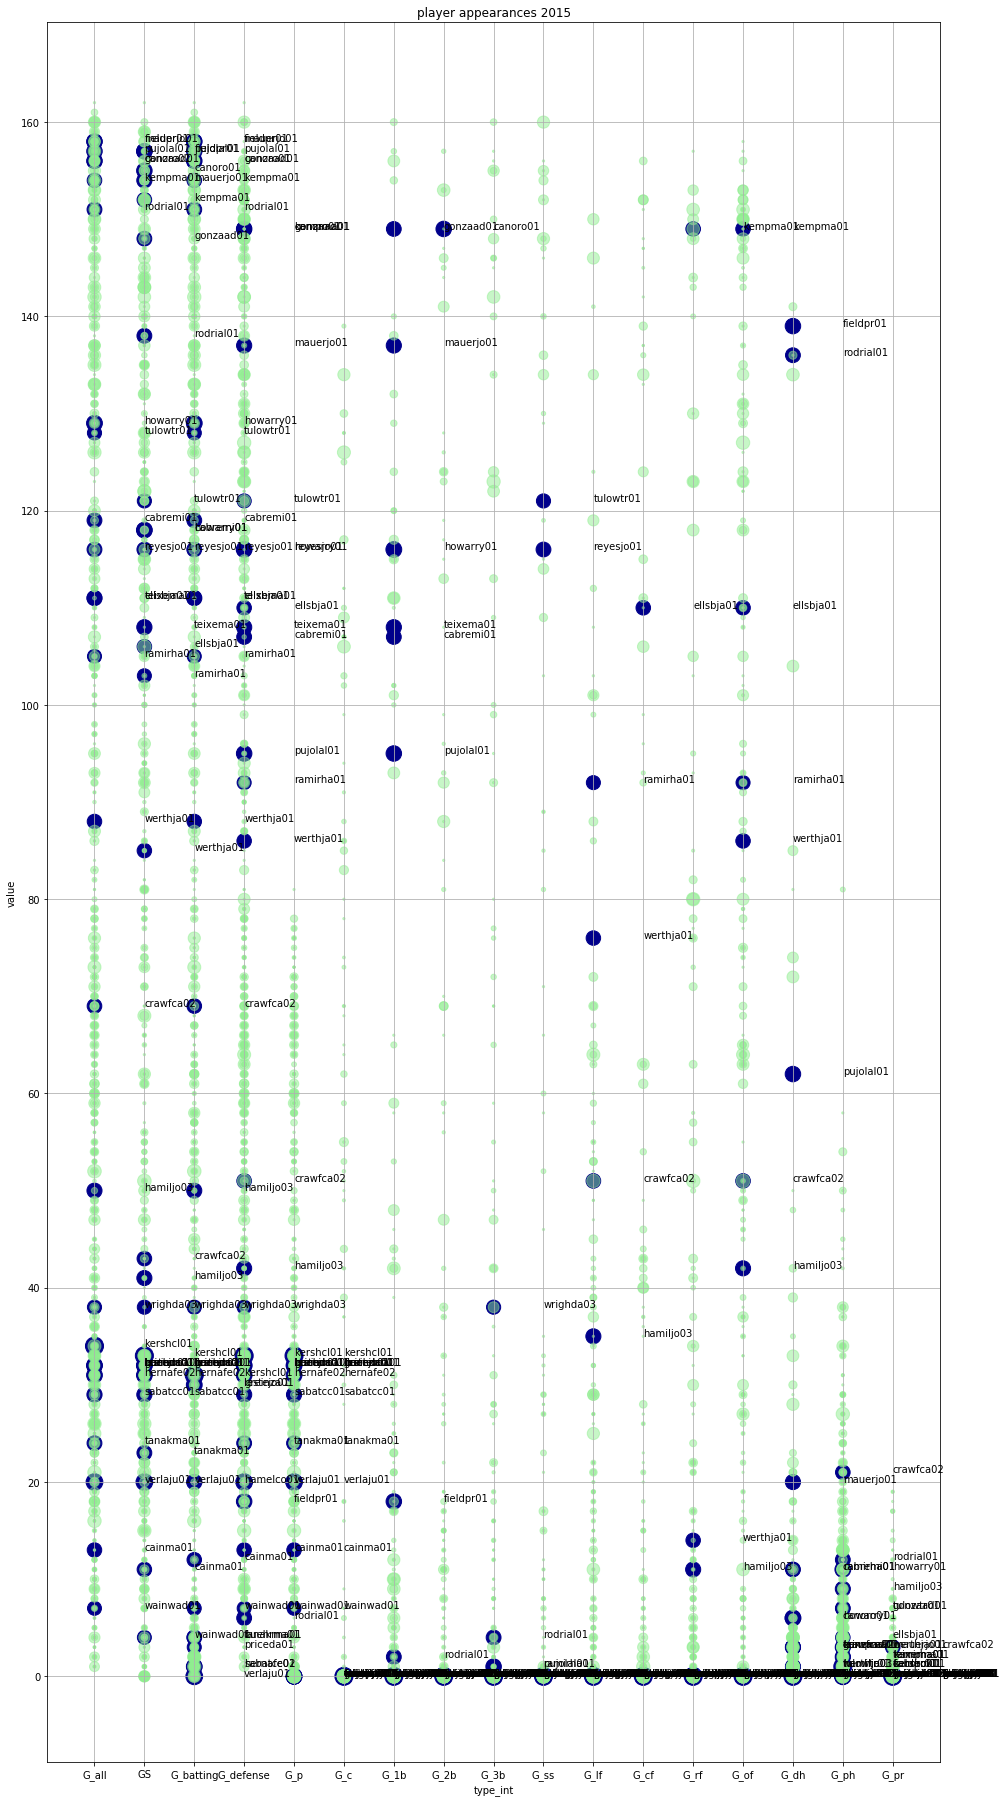

In [97]:
appearances_df = pd.read_csv('./baseballdatabank-master/core/Appearances.csv').set_index(['yearID'])
salary_club = 10000000
def draw_appearances_sal_plot(appear_df, year_salaries_df, yearID):
    df = appear_df.loc[yearID].groupby('playerID').sum()
    draw_df = df.stack()
    draw_df = draw_df.reset_index().rename(columns={'level_1':'type', 0:'value'}).set_index('playerID')
    type_defines = ['G_all', 'GS', 'G_batting', 'G_defense', 'G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss', 
                        'G_lf', 'G_cf', 'G_rf', 'G_of', 'G_dh', 'G_ph', 'G_pr']
    def convert_type_to_int(row):
        result = {}
        
        result['type_int'] = type_defines.index(row['type'])
        return pd.Series(result)
    draw_df['type_int'] = draw_df.apply(lambda row: convert_type_to_int(row), axis=1)
    salaries_df = year_salaries_df.loc[yearID].set_index('playerID')[['salary']]
    #top = salary_club_great_than(year_salaries_df, yearID, salary_club)
    top = 30
    top_salaries_df = salaries_df.nlargest(top, 'salary')
    other_salaries_df = salaries_df.nsmallest(len(salaries_df.index)-top, 'salary')
    draw_df_1 = draw_df.join(top_salaries_df, how='right').reset_index()
    ax1 = draw_df_1.plot.scatter(x='type_int', y='value', s=draw_df_1.salary/100000,
                   figsize=(16, 32), grid=True, color='DarkBlue',
                   title = 'player appearances '+str(yearID))
    for i, row in draw_df_1.iterrows():
        ax1.text(row['type_int']+1, row['value'], row['playerID'])
    #ax1.set_xticks(range(0, len(type_defines)))
    #ax1.set_xticklabels(type_defines)
    draw_df_2 = draw_df.join(other_salaries_df, how='right').reset_index()
    ax2 = draw_df_2.plot.scatter(x='type_int', y='value', s=draw_df_2.salary/100000, ax=ax1,
                   figsize=(16, 32), grid=True, alpha=0.5, color='LightGreen',
                   title = 'player appearances '+str(yearID))
    ax2.set_xticks(range(0, len(type_defines)))
    ax2.set_xticklabels(type_defines)

    
    #df.plot.scatter(x='')
    #top_salaries_df = df.loc[yearID].nlargest(10, 'salary')
    #print top_salaries_df
    #title = 'player salary with age ' + str(yearID)
    #year_df.plot.scatter(x='age', y='salary', 
    #                         figsize=(16, 8), grid=True,
    #                    title = title)
    
draw_appearances_sal_plot(appearances_df, year_salaries_df, 2015)

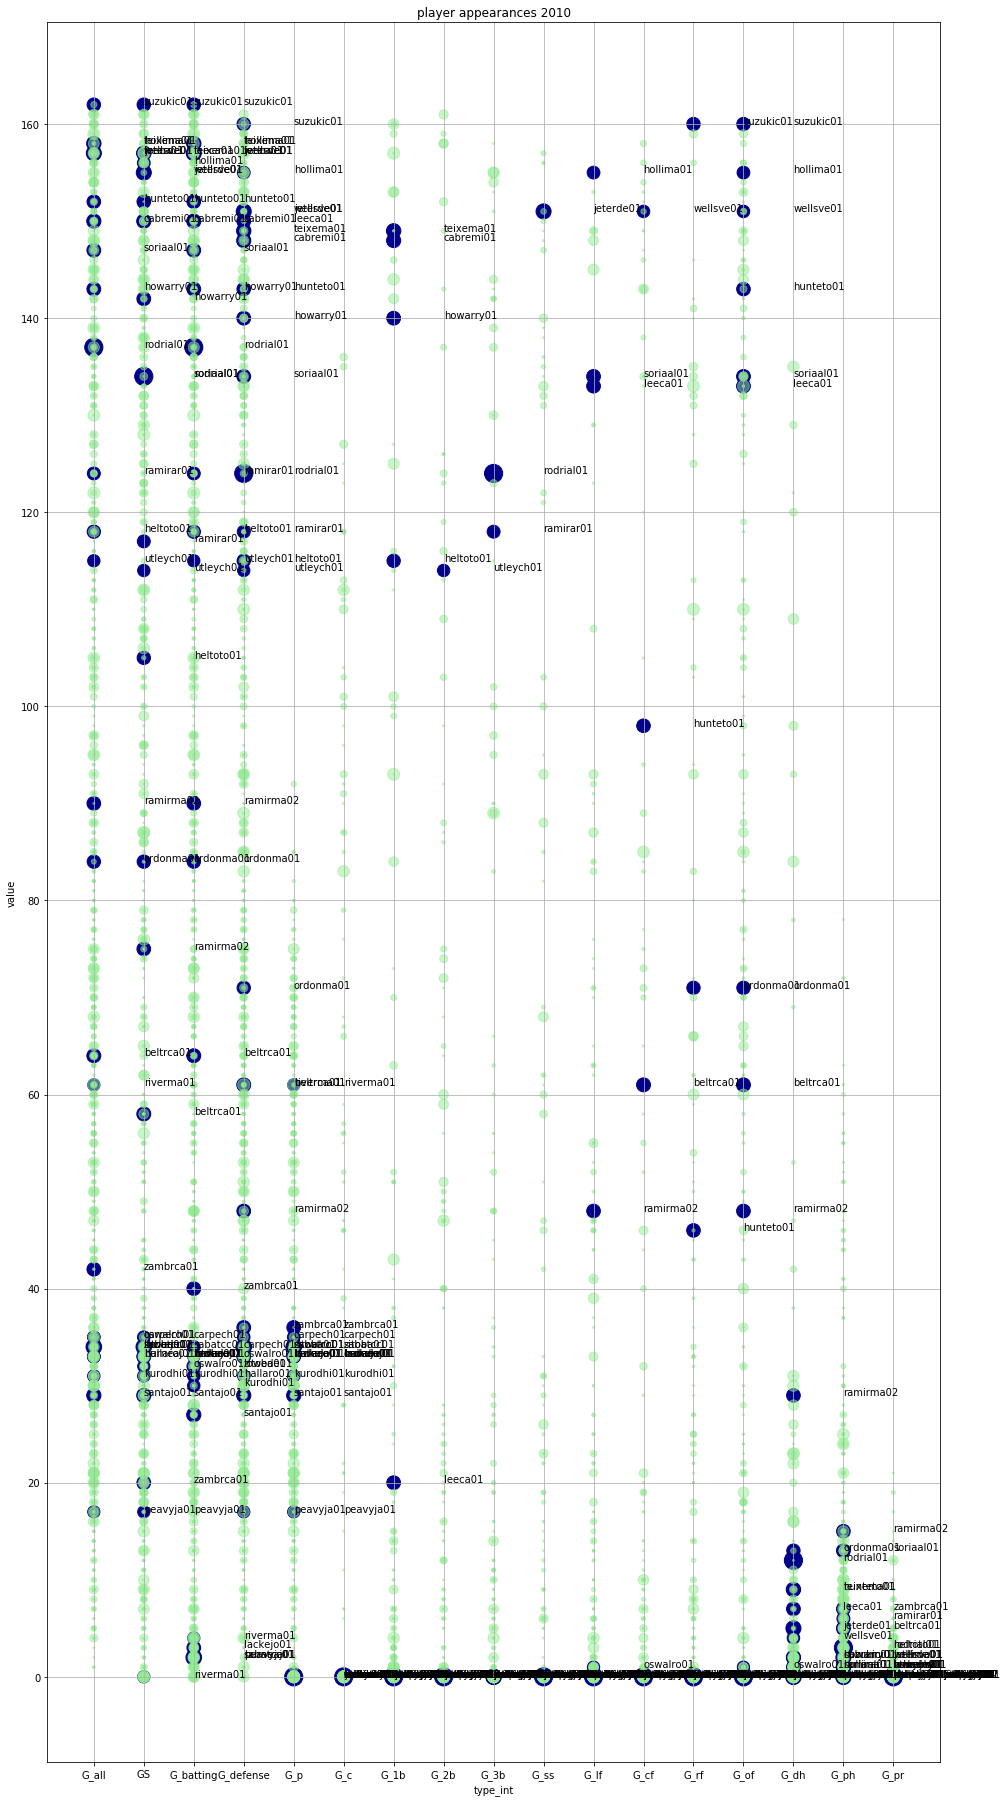

In [98]:
draw_appearances_sal_plot(appearances_df, year_salaries_df, 2010)

In [35]:
print ga_batting_df.swaplevel().loc[2015]

           stint    G     AB     R      H    2B   3B    HR    RBI    SB  \
playerID                                                                  
aardsda01      1   33    1.0   0.0    0.0   0.0  0.0   0.0    0.0   0.0   
abadfe01       1   62    0.0   0.0    0.0   0.0  0.0   0.0    0.0   0.0   
abreujo02      1  154  613.0  88.0  178.0  34.0  3.0  30.0  101.0   0.0   
achteaj01      1   11    0.0   0.0    0.0   0.0  0.0   0.0    0.0   0.0   
ackledu01      3  108  238.0  28.0   55.0  11.0  3.0  10.0   30.0   2.0   
adamecr01      1   26   53.0   4.0   13.0   1.0  1.0   0.0    3.0   0.0   
adamsau01      1   28    1.0   0.0    0.0   0.0  0.0   0.0    0.0   0.0   
adamsma01      1   60  175.0  14.0   42.0   9.0  0.0   5.0   24.0   1.0   
adcocna01      1   13    0.0   0.0    0.0   0.0  0.0   0.0    0.0   0.0   
adriaeh01      1   52  113.0  11.0   21.0   7.0  1.0   0.0   11.0   3.0   
affelje01      1   52    2.0   0.0    0.0   0.0  0.0   0.0    0.0   0.0   
aguilje01      1    7   1

绘制场均 batting / salary 的相关图形

* result['gab_ab'] = row['AB']/games
* result['gab_h'] = row['H']/games
* result['gab_2b'] = row['2B']/games
* result['gab_3b'] = row['3B']/games
* result['gab_hr'] = row['HR']/games
* result['gab_rbi'] = row['RBI']/games
* result['gab_sb'] = row['SB']/games
* result['gab_cs'] = row['CS']/games
* result['gab_bb'] = row['3B']/games
* result['gab_so'] = row['SO']/games
* result['gab_ibb'] = row['IBB']/games
* result['gab_hbp'] = row['HBP']/games
* result['gab_sh'] = row['SH']/games
* result['gab_sf'] = row['SF']/games
* result['gab_gidp'] = row['GIDP']/games

In [94]:

def find_ga_cols(df):
    import re
    result = []
    for col in df.columns:
        if re.match('ga\w_.*', col):
            result.append(col)
    return result        

In [99]:

    
def draw_gameavg_sal_plot_impl(gameavg_df, year_salaries_df, yearID, title, gameavg_df_cols):
    cols = gameavg_df_cols
    df = gameavg_df.swaplevel().loc[yearID][cols]
    print df
    draw_df = df.stack()
    draw_df = draw_df.reset_index().rename(columns={'level_1':'type', 0:'value'}).set_index('playerID')
    type_defines = cols
    def convert_type_to_int(row):
        result = {}    
        result['type_int'] = type_defines.index(row['type'])
        return pd.Series(result)
    draw_df['type_int'] = draw_df.apply(lambda row: convert_type_to_int(row), axis=1)
    salaries_df = year_salaries_df.loc[yearID].set_index('playerID')[['salary']]
    top = 30
    top_salaries_df = salaries_df.nlargest(top, 'salary')
    other_salaries_df = salaries_df.nsmallest(len(salaries_df.index)-top, 'salary')
    draw_df_1 = draw_df.join(top_salaries_df, how='inner').reset_index()
    print draw_df_1
    ax1 = draw_df_1.plot.scatter(x='type_int', y='value', s=draw_df_1.salary/100000,
                   figsize=(16, 32), grid=True, color='DarkBlue',
                   title = 'player game a '+str(yearID))
    for i, row in draw_df_1.iterrows():
        ax1.text(row['type_int']+0.2, row['value'], row['playerID'])
    #ax1.set_xticks(range(0, len(type_defines)))
    #ax1.set_xticklabels(type_defines)
    draw_df_2 = draw_df.join(other_salaries_df, how='inner').reset_index()
    ax2 = draw_df_2.plot.scatter(x='type_int', y='value', s=draw_df_2.salary/100000, ax=ax1,
                   figsize=(16, 32), grid=True, alpha=0.5, color='LightGreen',
                   title = title + ' '+ str(yearID))
    ax2.set_xticks(range(0, len(type_defines)))
    ax2.set_xticklabels(type_defines)
    

def draw_gameavg_sal_plot(gameavg_df, year_salaries_df, yearID, title):
    max_cols = 16
    cols = find_ga_cols(gameavg_df)
    if len(cols) <= max_cols:
        draw_gameavg_sal_plot_impl(gameavg_df, year_salaries_df, yearID, title, cols)
        return
    
    index = 1
    slice_num = int(round(len(cols)/float(max_cols)))
    slice_unit = len(cols)/slice_num
    slice_rem = len(cols)%slice_num
    start = end = 0
    while index < slice_num+1:
        size = slice_unit
        if slice_rem > 0:
            size += 1
            slice_rem -= 1
        end = start + size
        draw_gameavg_sal_plot_impl(gameavg_df, year_salaries_df, yearID, title+'-'+str(index), cols[start:end])
        start = end
        index += 1
    
    
    


             gab_2b    gab_3b    gab_ab    gab_bb    gab_cs  gab_gidp  \
playerID                                                                
aardsda01  0.000000  0.000000  0.030303  0.000000  0.000000  0.000000   
abadfe01   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abreujo02  0.220779  0.019481  3.980519  0.019481  0.000000  0.103896   
achteaj01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
ackledu01  0.101852  0.027778  2.203704  0.027778  0.018519  0.027778   
adamecr01  0.038462  0.038462  2.038462  0.038462  0.038462  0.000000   
adamsau01  0.000000  0.000000  0.035714  0.000000  0.000000  0.035714   
adamsma01  0.150000  0.000000  2.916667  0.000000  0.000000  0.016667   
adcocna01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
adriaeh01  0.134615  0.019231  2.173077  0.019231  0.038462  0.038462   
affelje01  0.000000  0.000000  0.038462  0.000000  0.000000  0.000000   
aguilje01  0.142857  0.000000  2.714286  0.000000  

      playerID      type     value  type_int    salary
0    buehrma01    gab_2b  0.000000         0  20000000
1    buehrma01    gab_3b  0.000000         1  20000000
2    buehrma01    gab_ab  0.218750         2  20000000
3    buehrma01    gab_bb  0.000000         3  20000000
4    buehrma01    gab_cs  0.000000         4  20000000
5    buehrma01  gab_gidp  0.000000         5  20000000
6    buehrma01     gab_h  0.031250         6  20000000
7    buehrma01   gab_hbp  0.000000         7  20000000
8    buehrma01    gab_hr  0.000000         8  20000000
9    buehrma01   gab_ibb  0.000000         9  20000000
10   buehrma01   gab_rbi  0.000000        10  20000000
11   buehrma01    gab_sb  0.000000        11  20000000
12   buehrma01    gab_sf  0.000000        12  20000000
13   buehrma01    gab_sh  0.031250        13  20000000
14   buehrma01    gab_so  0.093750        14  20000000
15   cabremi01    gab_2b  0.235294         0  22000000
16   cabremi01    gab_3b  0.008403         1  22000000
17   cabre

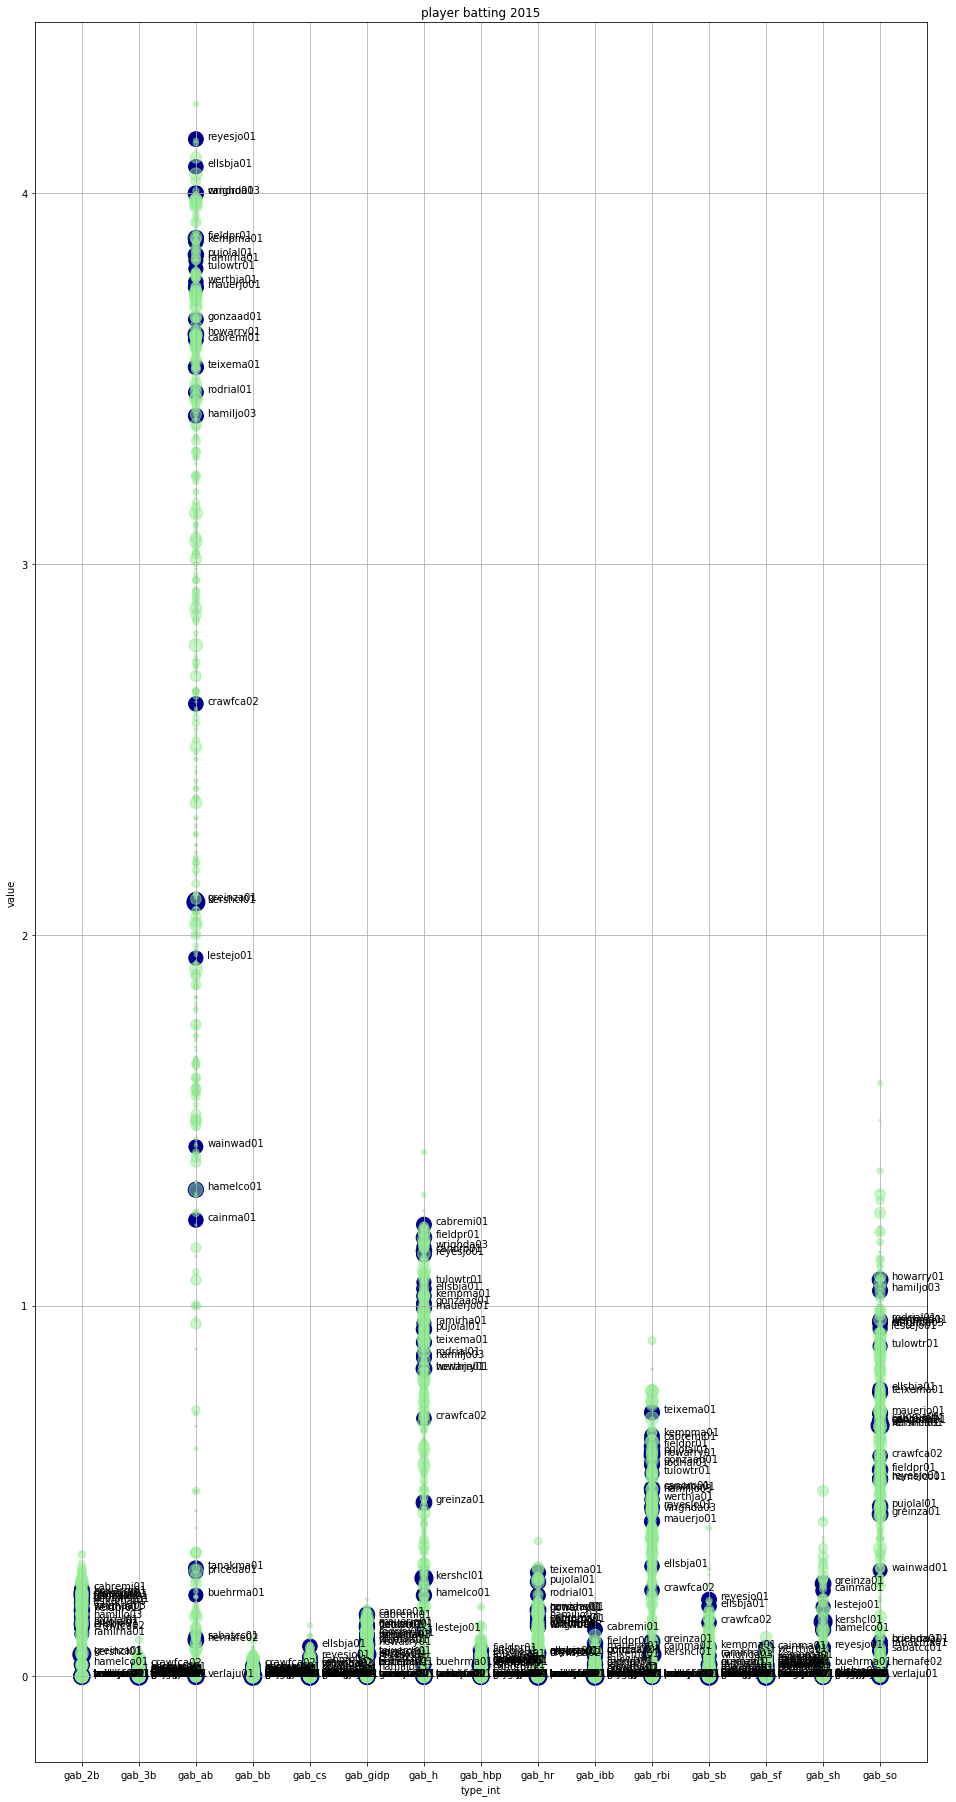

In [100]:
draw_gameavg_sal_plot(ga_batting_df, year_salaries_df, 2015, 'player batting')

             gab_2b    gab_3b    gab_ab    gab_bb    gab_cs  gab_gidp  \
playerID                                                                
aardsda01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
abadfe01   0.000000  0.000000  0.045455  0.000000  0.000000  0.000000   
abreubo01  0.266234  0.006494  3.720779  0.006494  0.064935  0.084416   
abreuto01  0.135802  0.012346  2.382716  0.012346  0.012346  0.098765   
accarje01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
aceveal01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
acostma01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
adamsmi03  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
affelje01  0.000000  0.000000  0.018868  0.000000  0.000000  0.000000   
albaljo01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
alberma01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
aldrico01  0.000000  0.200000  2.600000  0.200000  

      playerID      type     value  type_int    salary
0    beltrca01    gab_2b  0.171875         0  19401569
1    beltrca01    gab_3b  0.046875         1  19401569
2    beltrca01    gab_ab  3.437500         2  19401569
3    beltrca01    gab_bb  0.046875         3  19401569
4    beltrca01    gab_cs  0.015625         4  19401569
5    beltrca01  gab_gidp  0.062500         5  19401569
6    beltrca01     gab_h  0.875000         6  19401569
7    beltrca01   gab_hbp  0.015625         7  19401569
8    beltrca01    gab_hr  0.109375         8  19401569
9    beltrca01   gab_ibb  0.078125         9  19401569
10   beltrca01   gab_rbi  0.421875        10  19401569
11   beltrca01    gab_sb  0.046875        11  19401569
12   beltrca01    gab_sf  0.062500        12  19401569
13   beltrca01    gab_sh  0.000000        13  19401569
14   beltrca01    gab_so  0.609375        14  19401569
15   burneaj01    gab_2b  0.000000         0  16500000
16   burneaj01    gab_3b  0.000000         1  16500000
17   burne

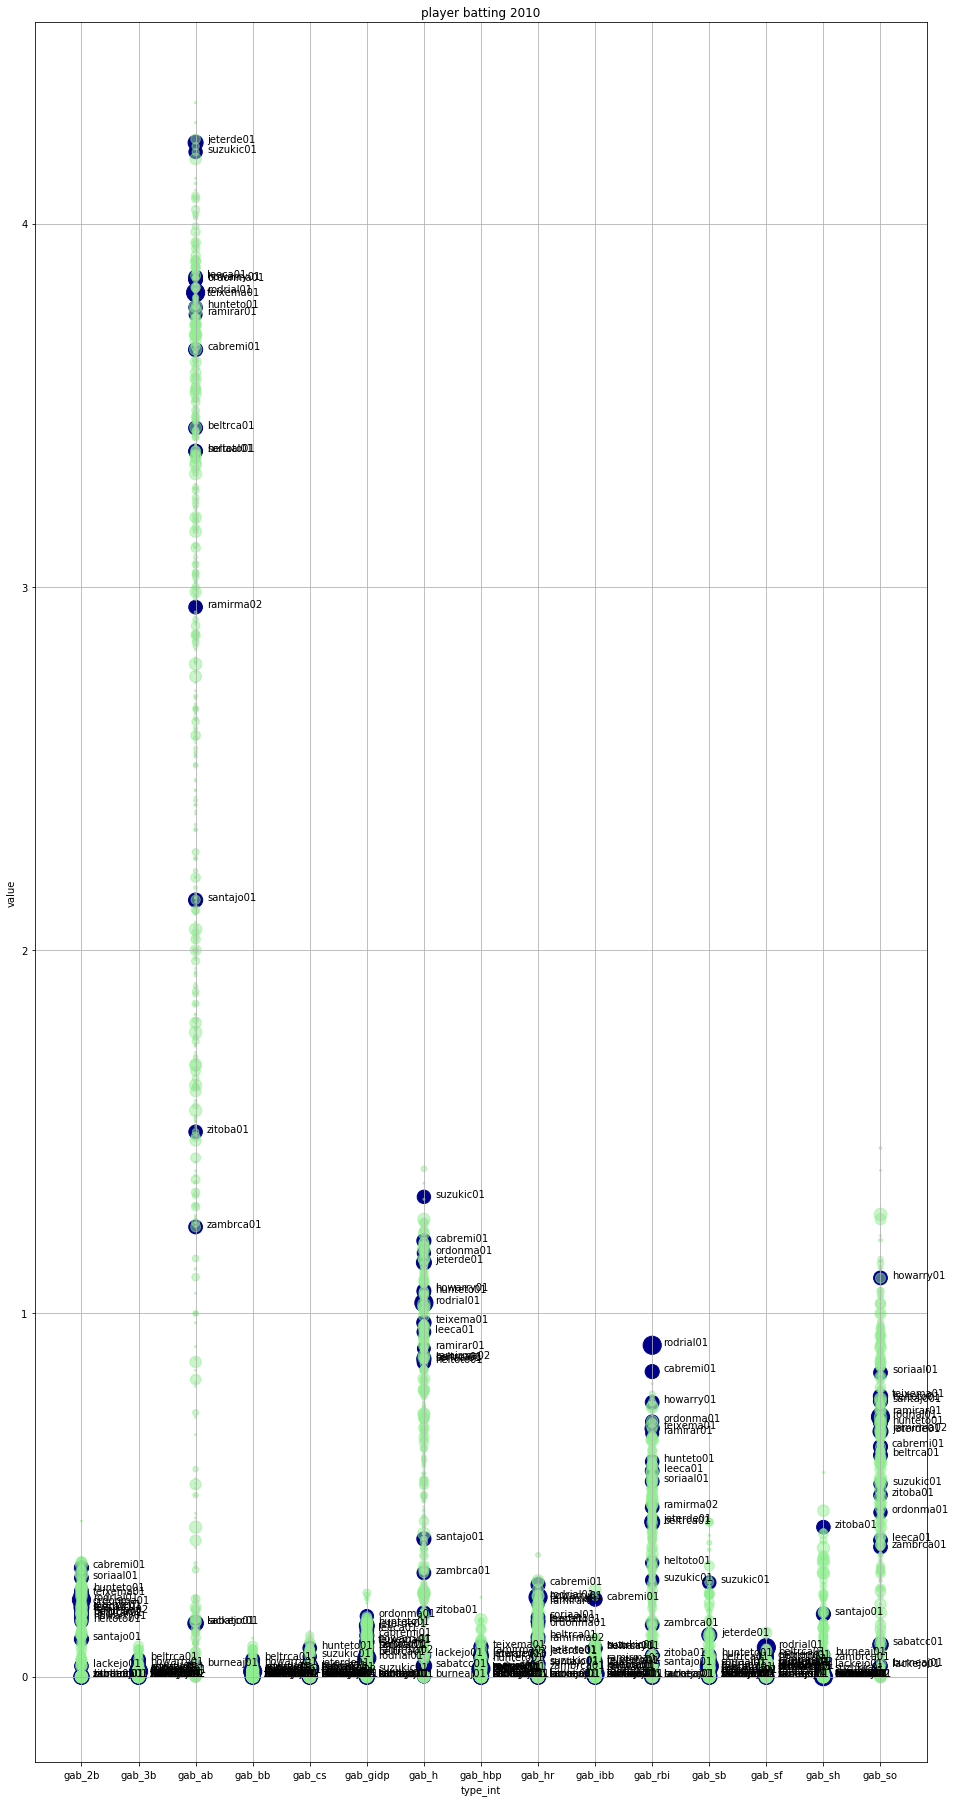

In [39]:
draw_gameavg_sal_plot(ga_batting_df, year_salaries_df, 2010, 'player batting')

           gap_baopp    gap_bb    gap_bfp    gap_bk  gap_completed    gap_era  \
playerID                                                                        
aardsda01   0.006697  0.424242   3.909091  0.000000            0.0   0.142424   
abadfe01    0.004048  0.306452   3.306452  0.000000            0.0   0.066935   
achteaj01   0.021000  0.545455   5.272727  0.000000            0.0   0.613636   
adamsau01   0.009857  0.464286   5.321429  0.000000            0.0   0.135000   
adcocna01   0.017000  0.923077   6.384615  0.000000            0.0   0.461538   
affelje01   0.005635  0.269231   3.134615  0.000000            0.0   0.112692   
alberan01   0.111000  2.000000  11.000000  0.000000            0.0   3.380000   
alberma01   0.007600  0.300000   4.966667  0.000000            0.0   0.040333   
albural01   0.004015  0.492537   4.044776  0.059701            0.0   0.062836   
alexasc01   0.059500  0.750000   6.250000  0.000000            0.0   1.125000   
allenco01   0.003129  0.3571

     playerID           type      value  type_int    salary
0   greinza01      gap_baopp   0.005844         0  25000000
1   greinza01         gap_bb   1.250000         1  25000000
2   greinza01        gap_bfp  26.343750         2  25000000
3   greinza01         gap_bk   0.000000         3  25000000
4   greinza01  gap_completed   1.000000         4  25000000
5   greinza01        gap_era   0.051875         5  25000000
6   greinza01      gap_games  32.000000         6  25000000
7   greinza01         gap_gf   0.000000         7  25000000
8   greinza01       gap_gidp   0.000000         8  25000000
9   greinza01          gap_h   4.625000         9  25000000
10  greinza01        gap_hbp   0.156250        10  25000000
11  greinza01         gap_hr   0.437500        11  25000000
12  hamelco01      gap_baopp   0.014937         0  23500000
13  hamelco01         gap_bb   1.937500         1  23500000
14  hamelco01        gap_bfp  27.500000         2  23500000
15  hamelco01         gap_bk   0.125000 

     playerID         type      value  type_int    salary
0   greinza01      gap_ibb   0.031250         0  25000000
1   greinza01   gap_ipouts  20.875000         1  25000000
2   greinza01   gap_losses   3.000000         2  25000000
3   greinza01        gap_r   1.343750         3  25000000
4   greinza01       gap_sf   0.062500         4  25000000
5   greinza01       gap_sh   0.187500         5  25000000
6   greinza01      gap_sho   0.000000         6  25000000
7   greinza01       gap_so   6.250000         7  25000000
8   greinza01  gap_started  32.000000         8  25000000
9   greinza01       gap_sv   0.000000         9  25000000
10  greinza01     gap_wins  19.000000        10  25000000
11  greinza01       gap_wp   0.218750        11  25000000
12  hamelco01      gap_ibb   0.093750         0  23500000
13  hamelco01   gap_ipouts  19.906250         1  23500000
14  hamelco01   gap_losses   8.000000         2  23500000
15  hamelco01        gap_r   2.750000         3  23500000
16  hamelco01 

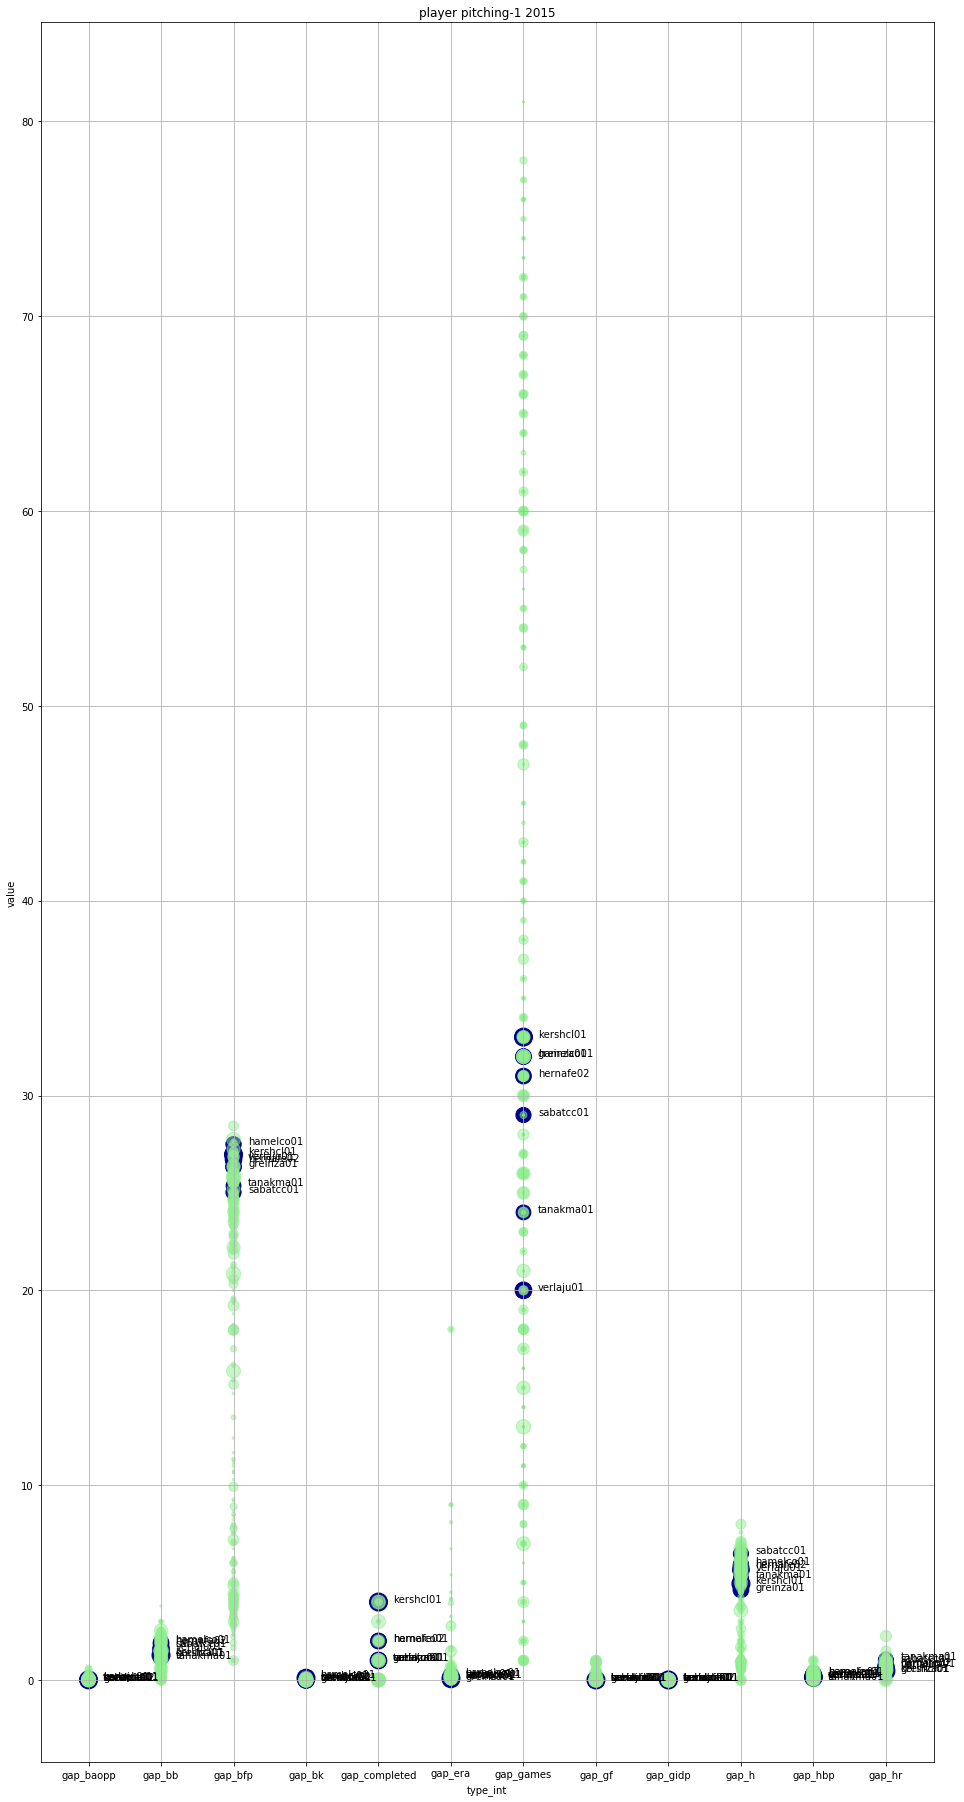

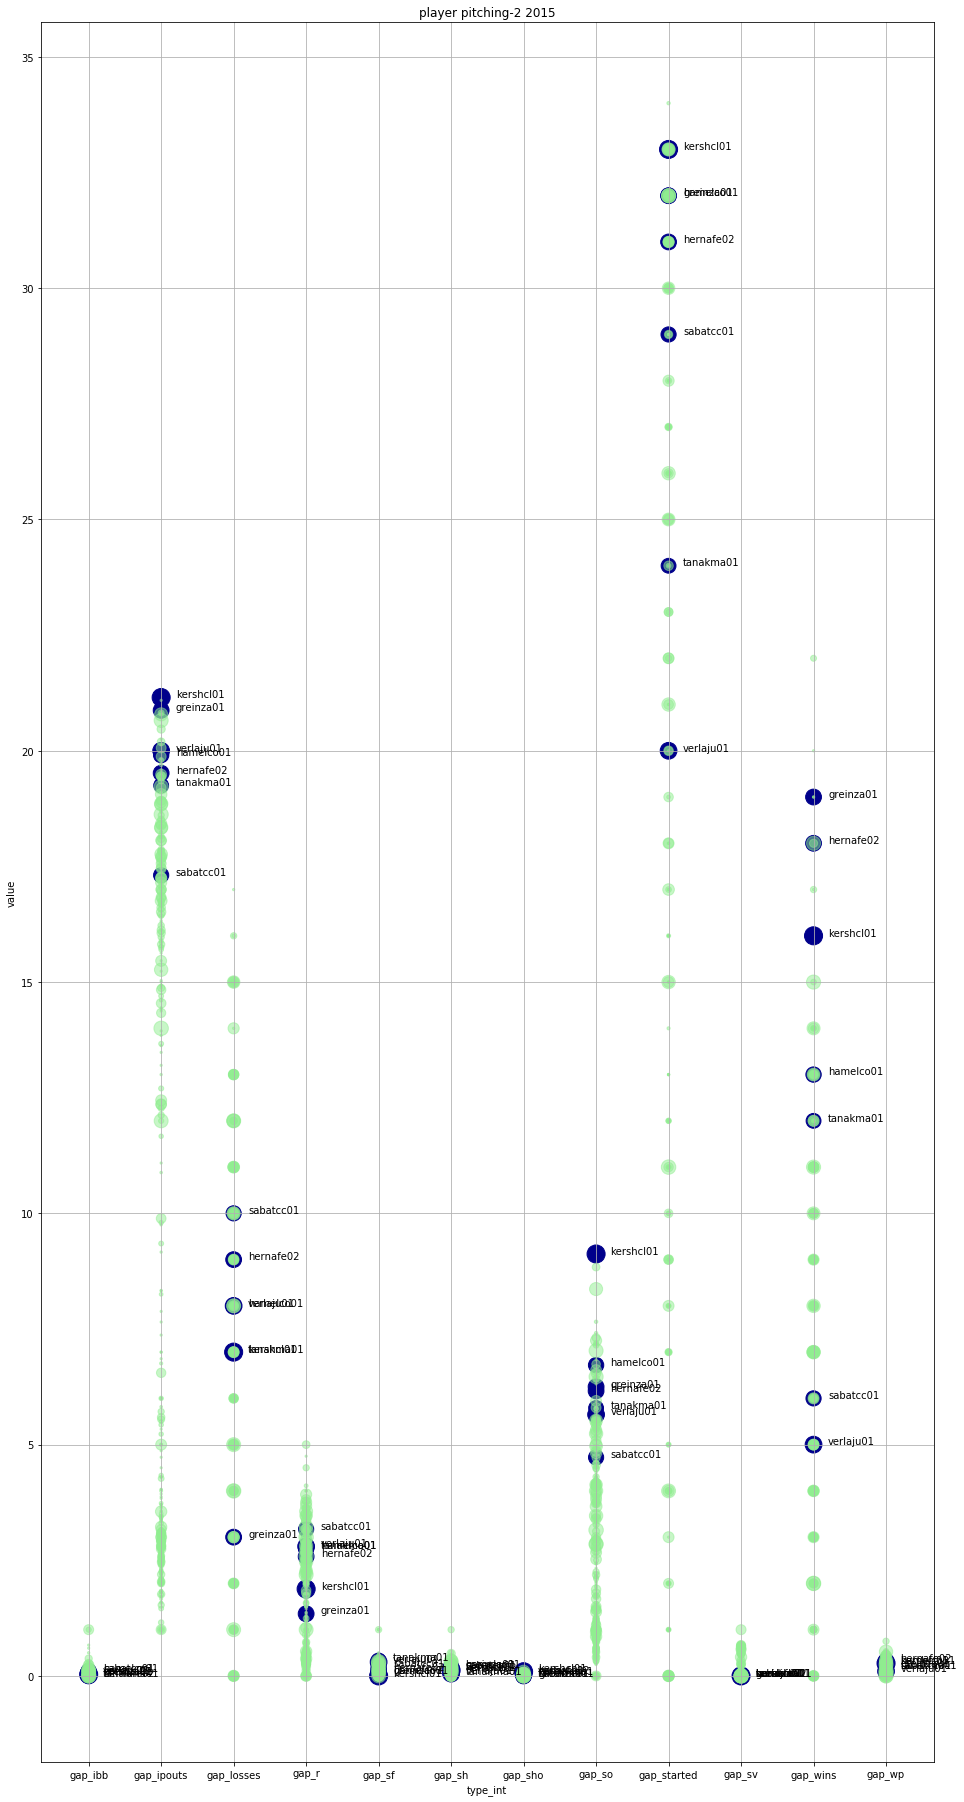

In [40]:
draw_gameavg_sal_plot(ga_pitching_df, year_salaries_df, 2015, 'player pitching')

           gap_baopp    gap_bb    gap_bfp    gap_bk  gap_completed    gap_era  \
playerID                                                                        
aardsda01   0.003736  0.471698   3.811321  0.000000            0.0   0.064906   
abadfe01    0.009091  0.227273   3.454545  0.000000            0.0   0.129091   
accarje01   0.080000  0.600000   6.800000  0.000000            0.0   1.620000   
aceveal01   0.020800  0.400000   5.300000  0.000000            0.0   0.300000   
acostma01   0.005341  0.439024   3.829268  0.000000            0.0   0.071951   
adamsmi03   0.002800  0.328571   3.828571  0.000000            0.0   0.025143   
affelje01   0.005472  0.452830   4.301887  0.000000            0.0   0.078113   
albaljo01   0.023100  0.800000   5.000000  0.000000            0.0   0.397000   
alberma01   0.004339  0.548387   5.306452  0.000000            0.0   0.072903   
ambrihe01   0.009941  0.500000   6.588235  0.000000            0.0   0.164412   
anderbr04   0.013526  1.1578

     playerID           type      value  type_int    salary
0   burneaj01      gap_baopp   0.008636         0  16500000
1   burneaj01         gap_bb   2.363636         1  16500000
2   burneaj01        gap_bfp  25.121212         2  16500000
3   burneaj01         gap_bk   0.000000         3  16500000
4   burneaj01  gap_completed   1.000000         4  16500000
5   burneaj01        gap_era   0.159394         5  16500000
6   burneaj01      gap_games  33.000000         6  16500000
7   burneaj01         gap_gf   0.000000         7  16500000
8   burneaj01       gap_gidp   0.000000         8  16500000
9   burneaj01          gap_h   6.181818         9  16500000
10  burneaj01        gap_hbp   0.575758        10  16500000
11  burneaj01         gap_hr   0.757576        11  16500000
12  lackejo01      gap_baopp   0.008394         0  18700000
13  lackejo01         gap_bb   2.181818         1  18700000
14  lackejo01        gap_bfp  28.181818         2  18700000
15  lackejo01         gap_bk   0.000000 

     playerID         type      value  type_int    salary
0   burneaj01      gap_ibb   0.060606         0  16500000
1   burneaj01   gap_ipouts  16.969697         1  16500000
2   burneaj01   gap_losses  15.000000         2  16500000
3   burneaj01        gap_r   3.575758         3  16500000
4   burneaj01       gap_sf   0.303030         4  16500000
5   burneaj01       gap_sh   0.212121         5  16500000
6   burneaj01      gap_sho   0.000000         6  16500000
7   burneaj01       gap_so   4.393939         7  16500000
8   burneaj01  gap_started  33.000000         8  16500000
9   burneaj01       gap_sv   0.000000         9  16500000
10  burneaj01     gap_wins  10.000000        10  16500000
11  burneaj01       gap_wp   0.484848        11  16500000
12  lackejo01      gap_ibb   0.060606         0  18700000
13  lackejo01   gap_ipouts  19.545455         1  18700000
14  lackejo01   gap_losses  11.000000         2  18700000
15  lackejo01        gap_r   3.454545         3  18700000
16  lackejo01 

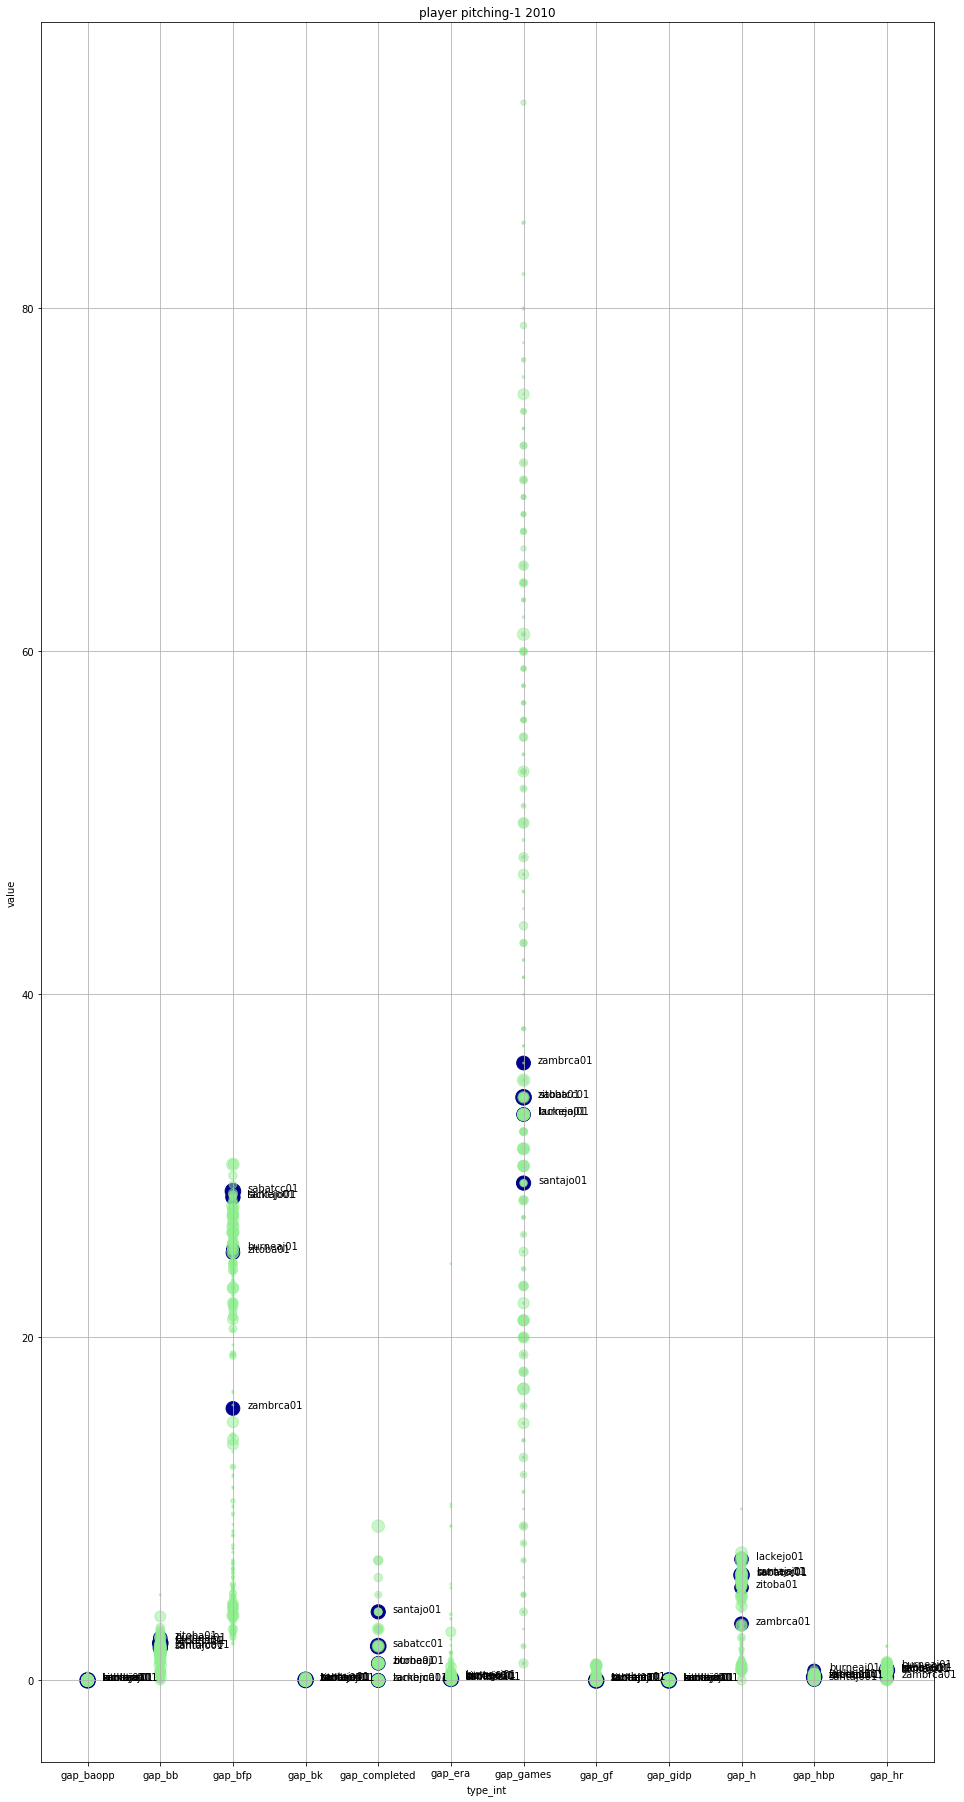

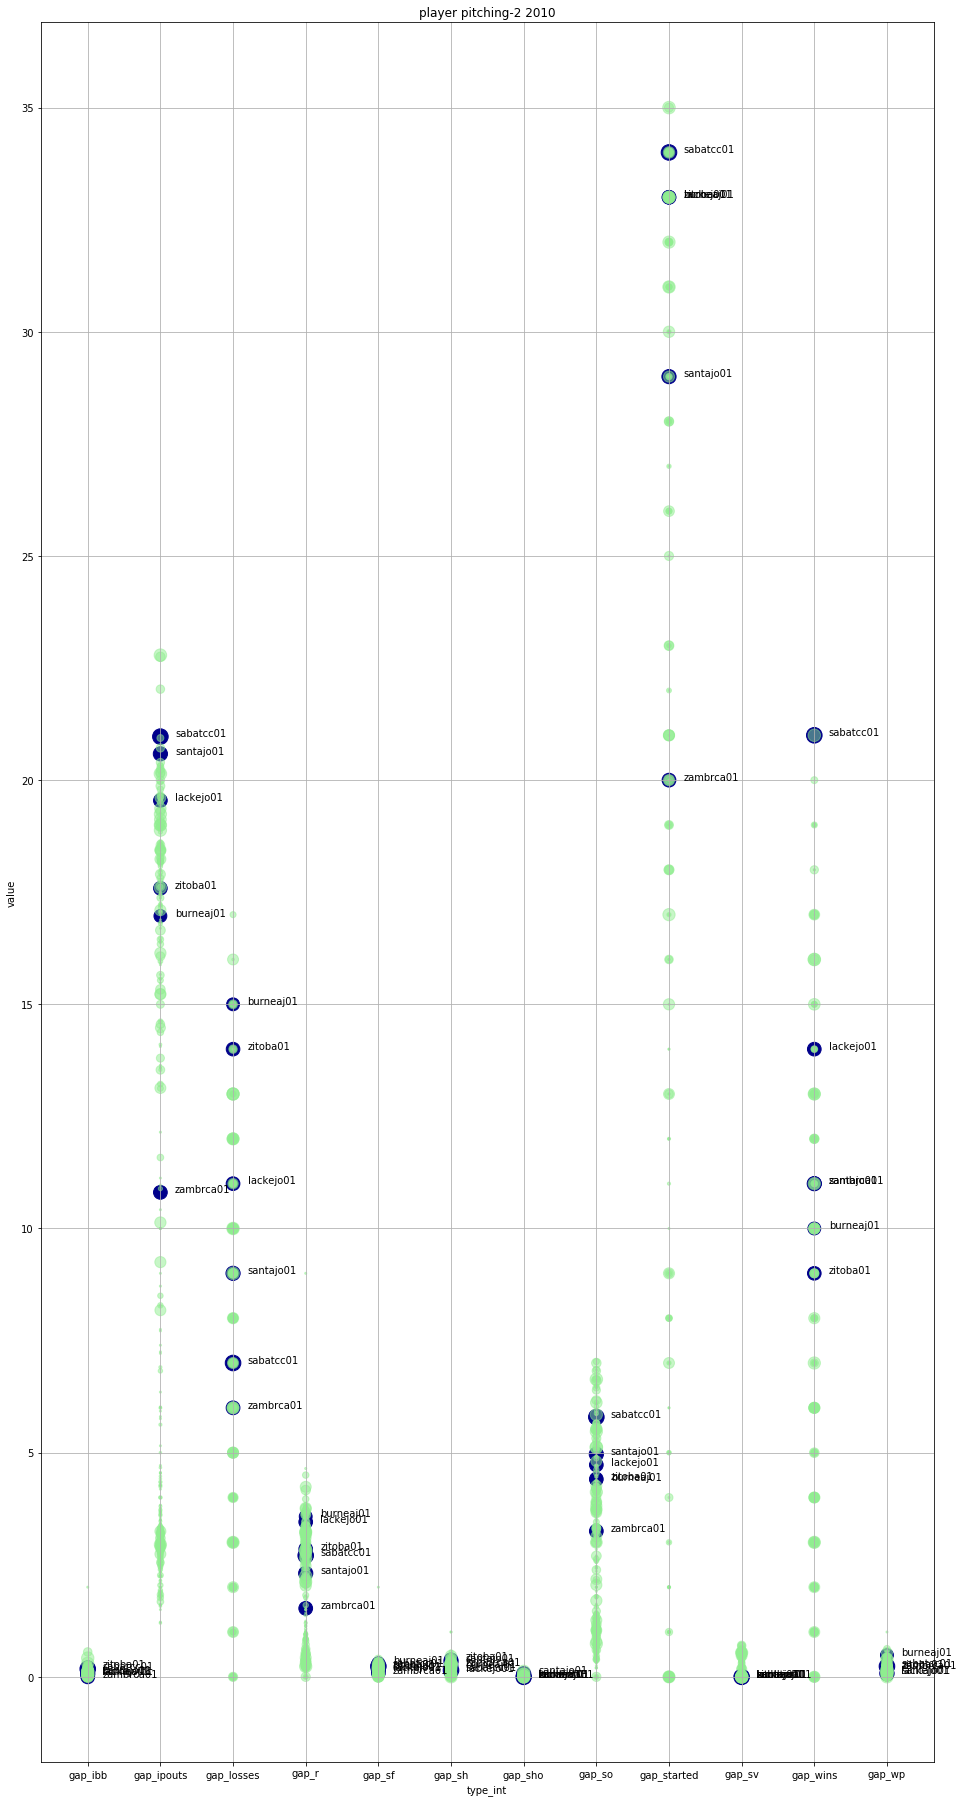

In [41]:
draw_gameavg_sal_plot(ga_pitching_df, year_salaries_df, 2010, 'player pitching')

对每一项球员表现数据验证统计假设：
H0 = Top 20薪酬的球员和总体的均值在该项数据上没有显著的差别

alpha = 0.05

In [102]:
def gameavg_subplot_impl(salary_top, gameavg_df, year_salaries_df, yearID, gameavg_col, fig, inner_grid):
    salaries_df = year_salaries_df.loc[yearID].set_index('playerID')[['salary']]
    top = salary_top
    top_salaries_df = salaries_df.nlargest(top, 'salary')
    other_salaries_df = salaries_df.nsmallest(len(salaries_df.index)-top, 'salary')
    gameavg_df = gameavg_df.loc[yearID].set_index('playerID')[[gameavg_col]]
    sample1_df = gameavg_df.join(top_salaries_df, how='inner')
    sample2_df = gameavg_df.join(other_salaries_df, how='inner')
    max1 = sample1_df[gameavg_col].max()
    max2 = sample2_df[gameavg_col].max()
    max_yval = max1
    if max1 < max2:
        max_yval = max2
    
    ax = plt.Subplot(fig, inner_grid[0])
    fig.add_subplot(sample1_df[[gameavg_col]].plot.box(ax=ax, color='r', sharey=True, title=gameavg_col+' of top '+str(salary_top)))
    ax.set_ylim([0, max_yval])
    ax = plt.Subplot(fig, inner_grid[1])
    fig.add_subplot(sample2_df[[gameavg_col]].plot.box(ax=ax, color='b', sharey=True, title=gameavg_col+' of other'))
    ax.set_ylim([0, max_yval])
    return
    

def gameavg_plots(salary_top, gameavg_df, year_salaries_df, yearID, title):
    import matplotlib.gridspec as gridspec
    print 'gameavg plots for ', title
    cols = find_ga_cols(gameavg_df)
    if len(cols) == 0:
        return
    ncols = 4
    nrows = len(cols) / ncols
    if len(cols) % ncols:
        nrows += 1
    fig = plt.figure(figsize=(25, 32))
    outer = gridspec.GridSpec(nrows, ncols, wspace=0.2, hspace=0.2)
    #fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,32))
    
    gameavg_df = gameavg_df.reset_index().set_index('yearID')
    for idx, col in enumerate(cols):
        #rows_idx = idx / ncols
        #cols_idx = idx % ncols
        inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[idx], wspace=0.1, hspace=0.1)
        gameavg_subplot_impl(salary_top, gameavg_df, year_salaries_df, yearID, col, fig, inner)
        
    
    

gameavg plots for  player batting


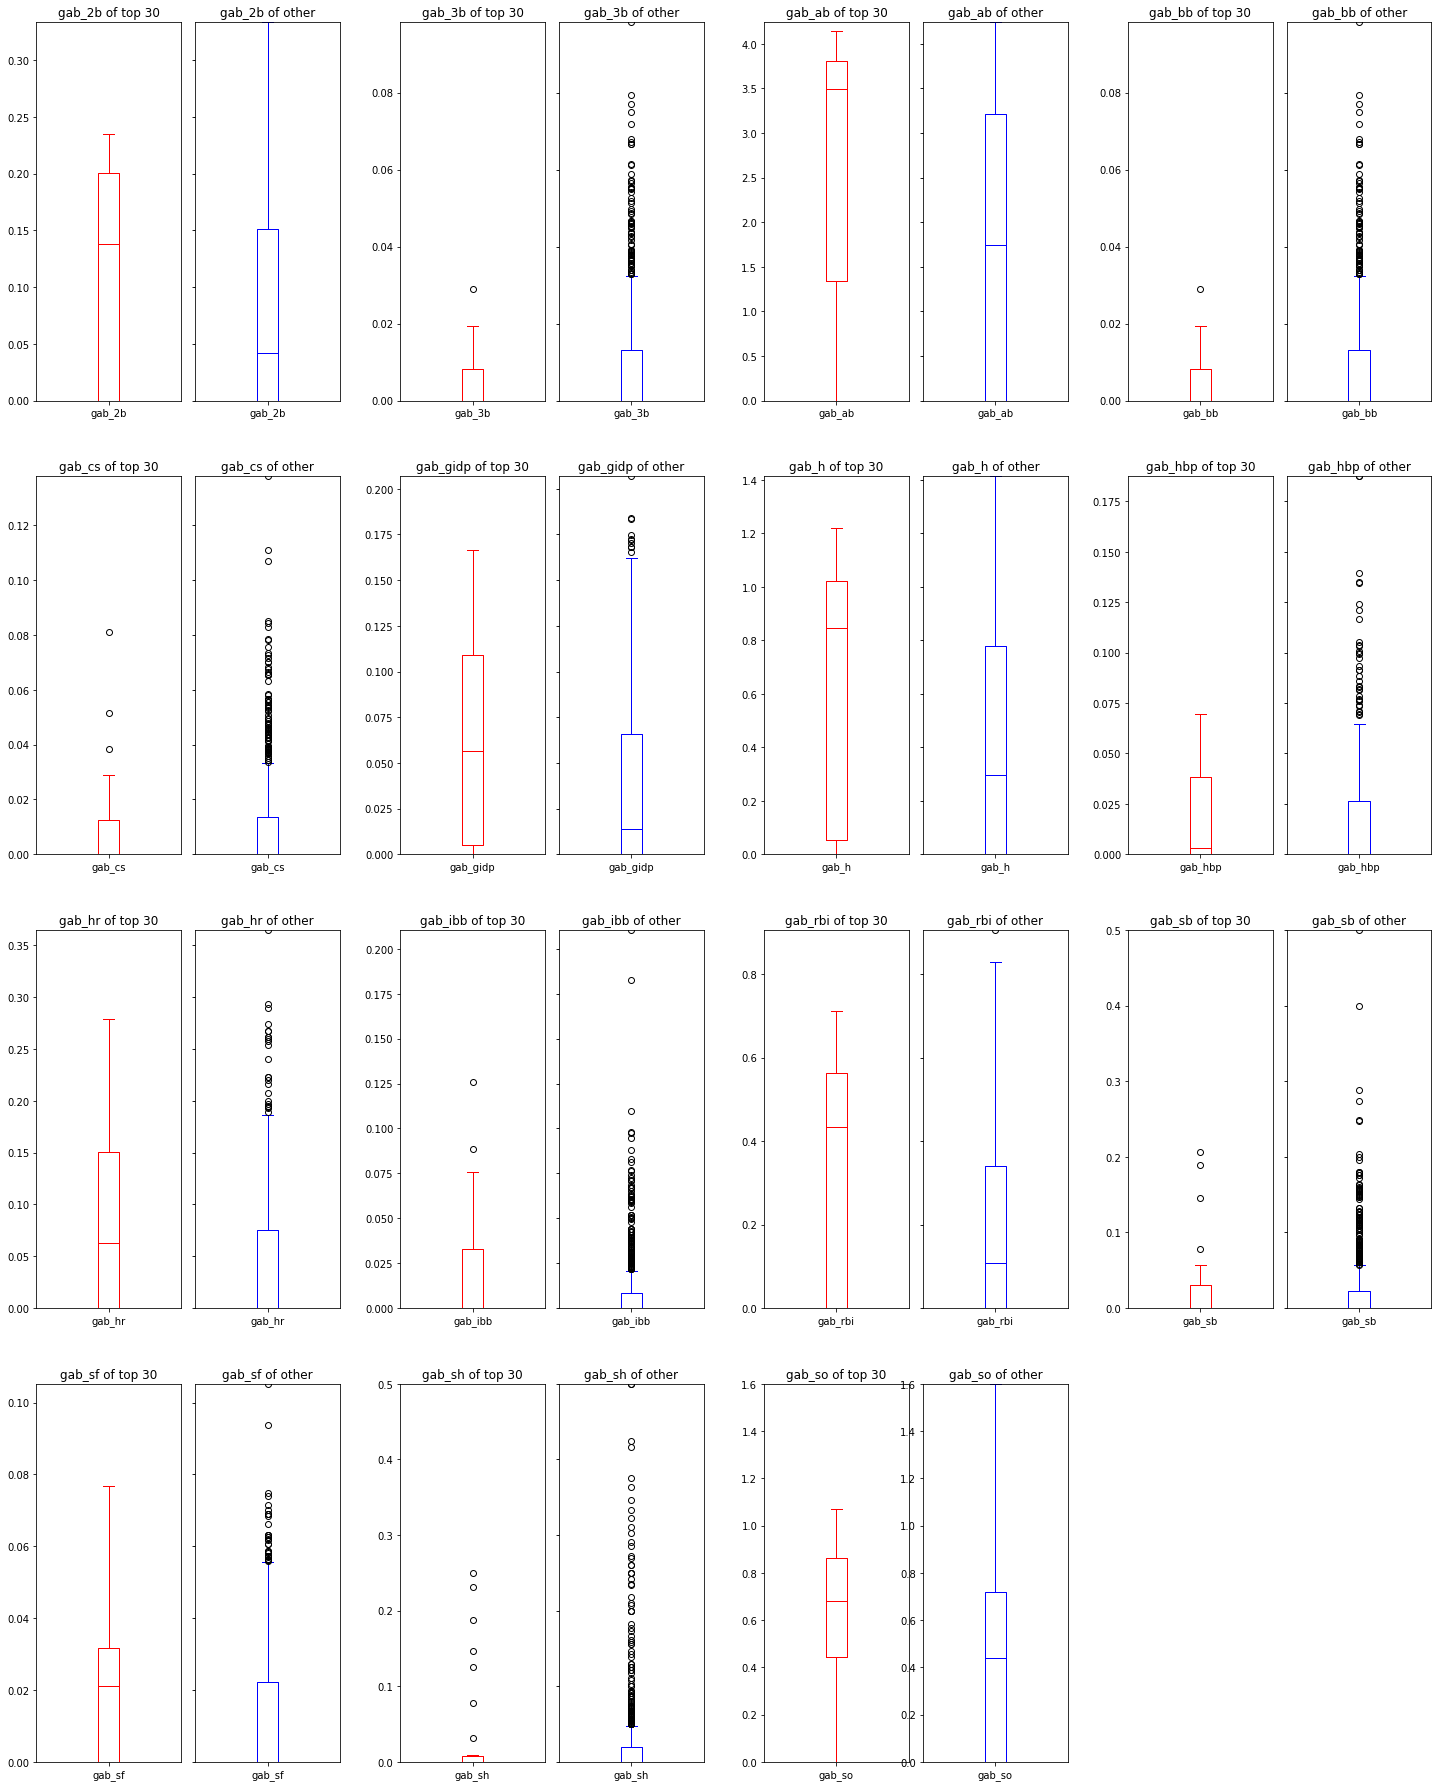

In [104]:
gameavg_plots(30, ga_batting_df, year_salaries_df, 2015, 'player batting')

gameavg plots for  player pitching


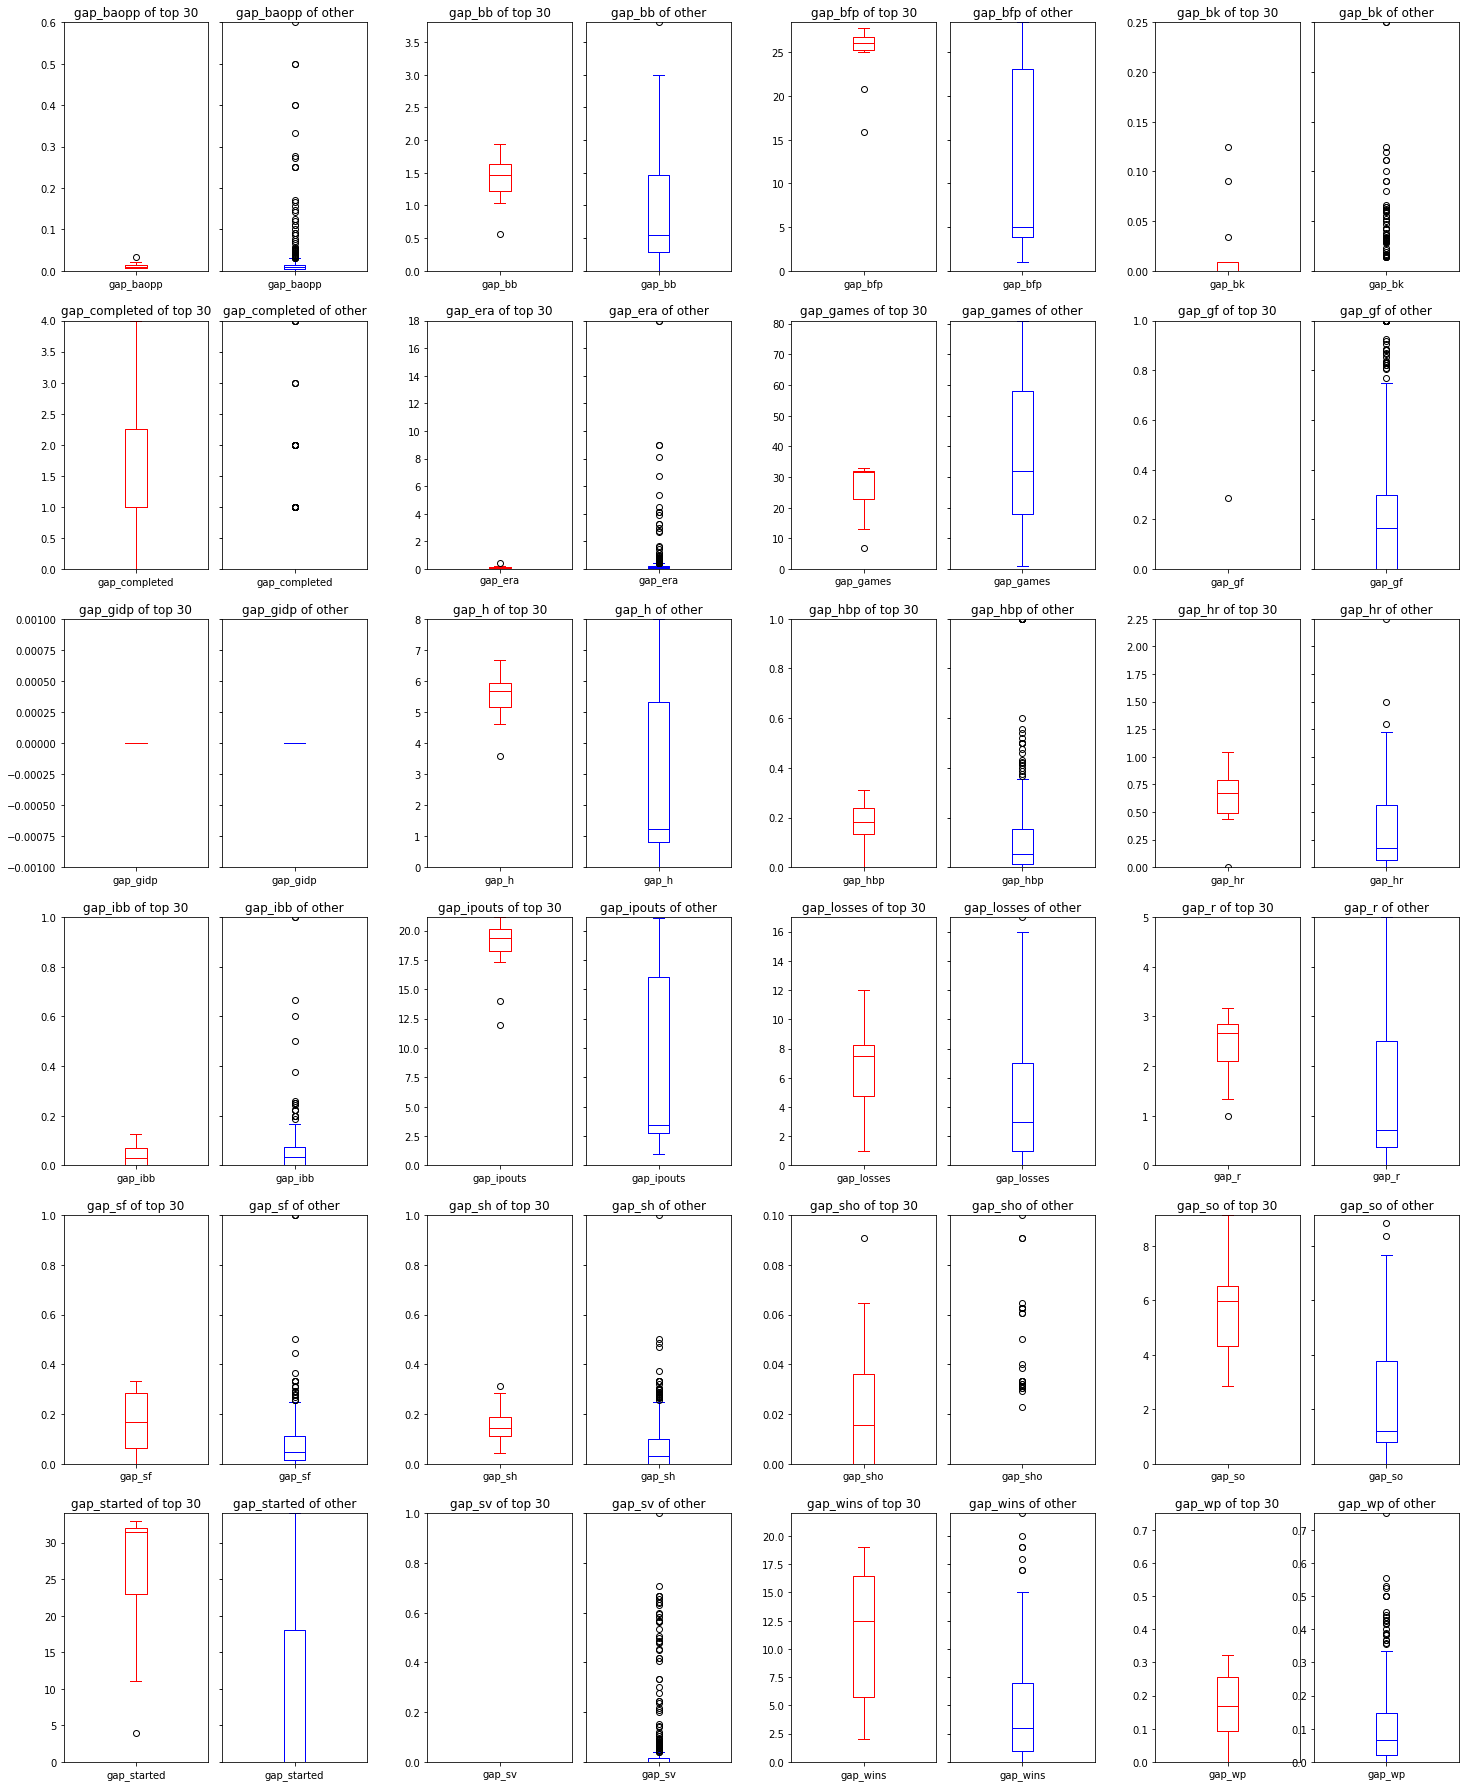

In [106]:
gameavg_plots(30, ga_pitching_df, year_salaries_df, 2015, 'player pitching')

gameavg plots for  player fielding


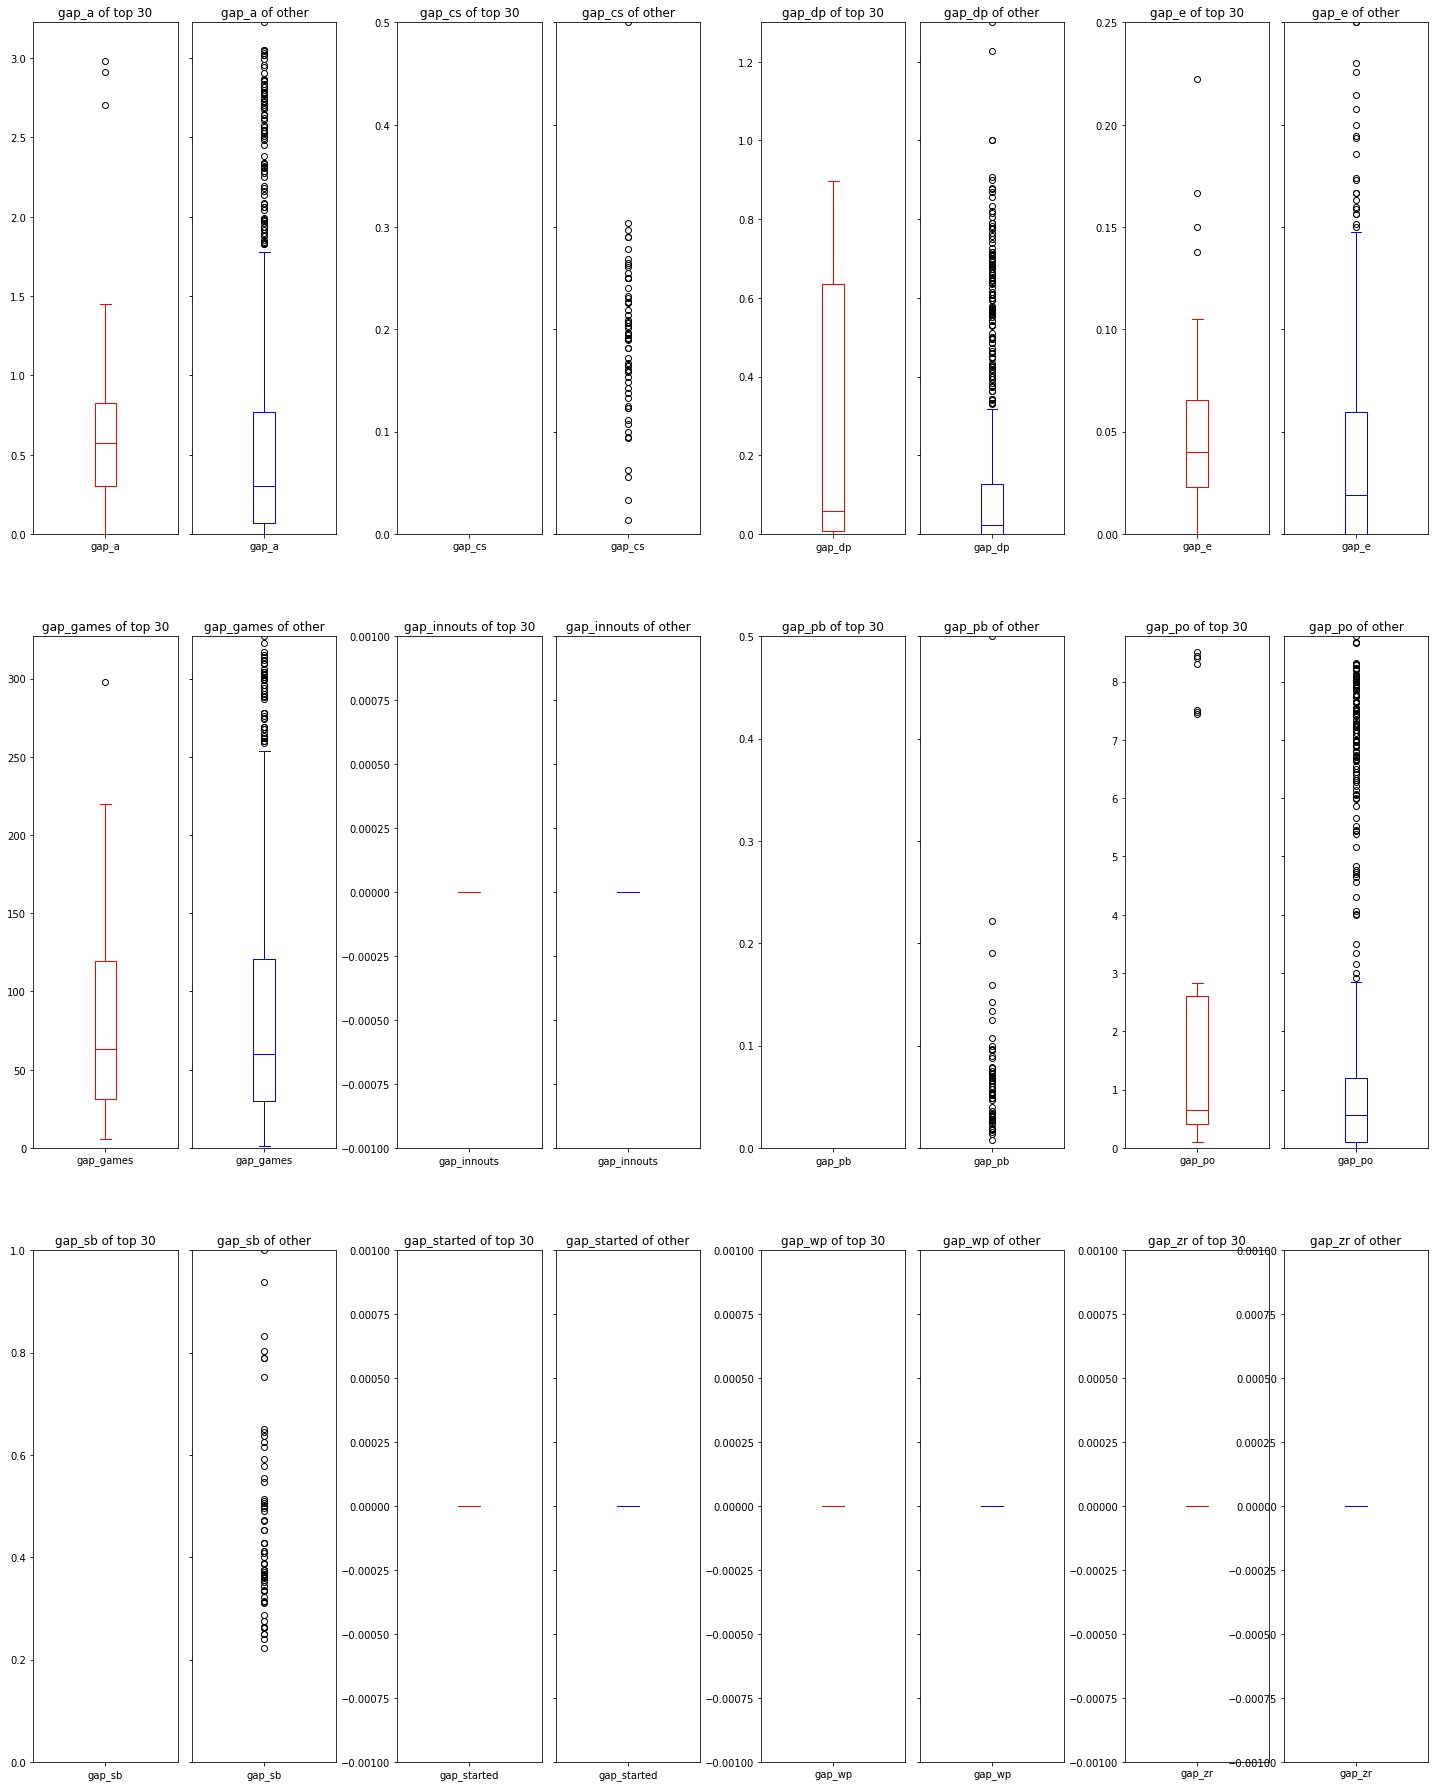

In [107]:
gameavg_plots(30, ga_fielding_df, year_salaries_df, 2015, 'player fielding')